In [186]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import utils as ut

# Distinguishability of Ranked Match Distributions

## Data

In [187]:
first_match = pd.read_csv("/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/data/most_probable_new.csv")
second_match= pd.read_csv("/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/data/second_new.csv")
last_match = pd.read_csv("/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/data/last_new.csv")

In [188]:
# removing incomplete rows (missing separation or off-axis angle) - NOTE: Removed ~ 20,000 rows (did not remove before making bins in old version)
first_match = first_match[first_match["dist_arcsec"].notna() & first_match["min_theta_mean"].notna()]
second_match = second_match[second_match["dist_arcsec"].notna() & second_match["min_theta_mean"].notna()]
last_match = last_match[last_match["dist_arcsec"].notna() & last_match["min_theta_mean"].notna()]

In [189]:
bin_edges = ut.create_bins_min_count(first_match, "dist_arcsec", min_count = 1000)

## Results - First- and Second-Best Match Distributions

### G Mean Magnitude

In [190]:
variable = "phot_g_mean_mag"
filter_column1 = "dist_arcsec"
filter_column2 = "min_theta_mean"
filter_count = "first"
unique_id = "chandra_source_id"

# filter 1 and 2 range (separation)
filter1 = bin_edges[:-1]
filter2 = bin_edges[1:]

# filter 3 and 4 range (off-axis angle)
filter3 = [0, 3, 5]
filter4 = [3, 5, float("inf")] #

# KS test results
data = []

for i in range(len(filter1)):
    for j in range(len(filter3)):
        ks_test_results = ut.ks_test_filter_ranges(first_match, second_match, variable, filter_column1, filter_column2, 
                                                     filter1[i], filter2[i], filter3[j], filter4[j],
                                                     unique_id = unique_id, filter_count = filter_count)
        
        data.append({'statistic': ks_test_results[0], 'pvalue': ks_test_results[1], 
                                   'min_sep': filter1[i], 'max_sep': filter2[i], 'med_sep': (filter1[i] + filter2[i])/2,
                                   'min_offaxis': filter3[j], 'max_offaxis': filter4[j], 
                                   'filter_by': filter_count, 'n_first': ks_test_results[2], 'n_second': ks_test_results[3]})
        
ks_test_results_df = pd.DataFrame(data)

ks_test_results_df.to_csv("/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/data/processed_data/Gmean_ks_test_results.csv", index = False)

print(ks_test_results_df.head())

   statistic        pvalue   min_sep   max_sep   med_sep  min_offaxis  \
0   0.311544  3.200621e-31  0.000000  0.030257  0.015129            0   
1   0.430622  8.930222e-18  0.000000  0.030257  0.015129            3   
2   0.513889  5.026482e-09  0.000000  0.030257  0.015129            5   
3   0.268613  3.859048e-22  0.030257  0.048175  0.039216            0   
4   0.311005  2.491020e-09  0.030257  0.048175  0.039216            3   

   max_offaxis filter_by  n_first  n_second  
0          3.0     first      719       719  
1          5.0     first      209       209  
2          inf     first       72        72  
3          3.0     first      685       685  
4          5.0     first      209       209  


#### Thresholds 

In [191]:
# Overall
overall_sep_01 = ks_test_results_df[ks_test_results_df["pvalue"] > 0.01].max_sep.min()
overall_sep_05 = ks_test_results_df[ks_test_results_df["pvalue"] > 0.05].max_sep.min()
overall_sep_10 = ks_test_results_df[ks_test_results_df["pvalue"] > 0.10].max_sep.min()

# 0-3 arcmin off-axis angle
offaxis_0_sep_01 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.01) & (ks_test_results_df["min_offaxis"] == 0)].max_sep.min()
offaxis_0_sep_05 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.05) & (ks_test_results_df["min_offaxis"] == 0)].max_sep.min()
offaxis_0_sep_10 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.10) & (ks_test_results_df["min_offaxis"] == 0)].max_sep.min()

# 3-5 arcmin off-axis angle
offaxis_3_sep_01 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.01) & (ks_test_results_df["min_offaxis"] == 3)].max_sep.min()
offaxis_3_sep_05 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.05) & (ks_test_results_df["min_offaxis"] == 3)].max_sep.min()
offaxis_3_sep_10 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.10) & (ks_test_results_df["min_offaxis"] == 3)].max_sep.min()

# >5 arcmin off-axis angle
offaxis_5_sep_01 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.01) & (ks_test_results_df["min_offaxis"] == 5)].max_sep.min()
offaxis_5_sep_05 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.05) & (ks_test_results_df["min_offaxis"] == 5)].max_sep.min()
offaxis_5_sep_10 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.10) & (ks_test_results_df["min_offaxis"] == 5)].max_sep.min()

thresholds = [{"sig_lvl": 0.01, "offaxis_stratif": "overall", "sep_threshold": overall_sep_01},
              {"sig_lvl": 0.05, "offaxis_stratif": "overall", "sep_threshold": overall_sep_05},
              {"sig_lvl": 0.10, "offaxis_stratif": "overall", "sep_threshold": overall_sep_10},
              {"sig_lvl": 0.01, "offaxis_stratif": "0-3", "sep_threshold": offaxis_0_sep_01},
              {"sig_lvl": 0.05, "offaxis_stratif": "0-3", "sep_threshold": offaxis_0_sep_05},
              {"sig_lvl": 0.10, "offaxis_stratif": "0-3", "sep_threshold": offaxis_0_sep_10},
              {"sig_lvl": 0.01, "offaxis_stratif": "3-5", "sep_threshold": offaxis_3_sep_01},
              {"sig_lvl": 0.05, "offaxis_stratif": "3-5", "sep_threshold": offaxis_3_sep_05},
              {"sig_lvl": 0.10, "offaxis_stratif": "3-5", "sep_threshold": offaxis_3_sep_10},
              {"sig_lvl": 0.01, "offaxis_stratif": ">5", "sep_threshold": offaxis_5_sep_01},
              {"sig_lvl": 0.05, "offaxis_stratif": ">5", "sep_threshold": offaxis_5_sep_05},
              {"sig_lvl": 0.10, "offaxis_stratif": ">5", "sep_threshold": offaxis_5_sep_10}]

thresholds = pd.DataFrame(thresholds)

thresholds.to_csv("/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/data/processed_data/Gmean_separation_thresholds.csv", index = False)

print(thresholds)

    sig_lvl offaxis_stratif  sep_threshold
0      0.01         overall       0.646228
1      0.05         overall       0.719012
2      0.10         overall       0.945972
3      0.01             0-3       0.646228
4      0.05             0-3       0.719012
5      0.10             0-3       0.945972
6      0.01             3-5       1.061833
7      0.05             3-5       1.061833
8      0.10             3-5       1.061833
9      0.01              >5       2.165748
10     0.05              >5       2.165748
11     0.10              >5       2.165748


#### Plots

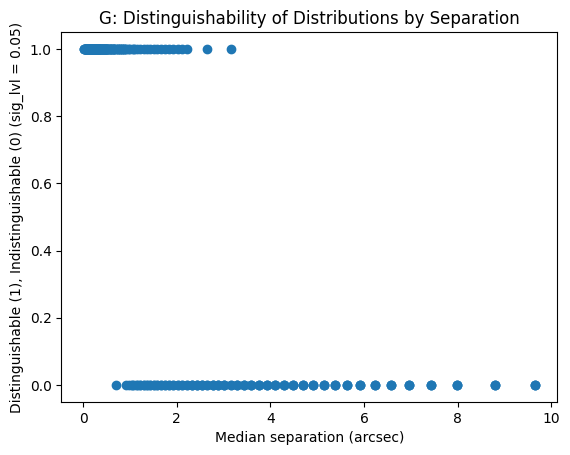

<Figure size 640x480 with 0 Axes>

In [192]:
# Make p-values binary (0.05)
ks_test_results_df['pvalue_binary'] = ks_test_results_df['pvalue'].apply(lambda x: 1 if x < 0.05 else 0)

# Plot binary y axis for p-values vs separation
plt.plot(ks_test_results_df['med_sep'], ks_test_results_df['pvalue_binary'], 'o')
plt.xlabel('Median separation (arcsec)')
plt.ylabel('Distinguishable (1), Indistinguishable (0) (sig_lvl = 0.05)')
plt.title('G: Distinguishability of Distributions by Separation')
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/GMean/binary_pvalue_vs_median_separation_aggregate_gmean.png')

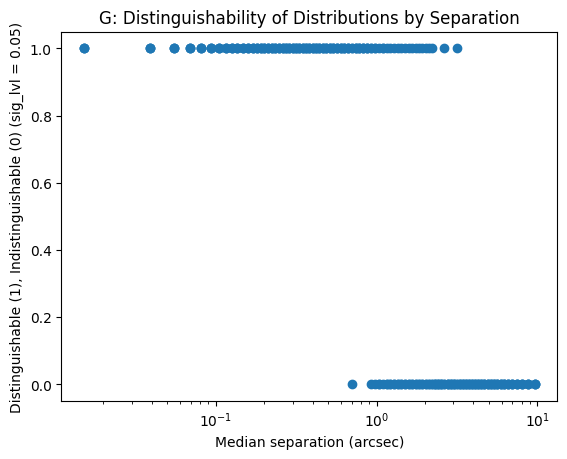

<Figure size 640x480 with 0 Axes>

In [193]:
# Plot binary y axis for p-values vs separation
plt.plot(ks_test_results_df['med_sep'], ks_test_results_df['pvalue_binary'], 'o')
plt.xlabel('Median separation (arcsec)')
plt.ylabel('Distinguishable (1), Indistinguishable (0) (sig_lvl = 0.05)')
plt.title('G: Distinguishability of Distributions by Separation')
plt.xscale('log')
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/GMean/binary_pvalue_vs_log_median_separation_aggregate_gmean.png')

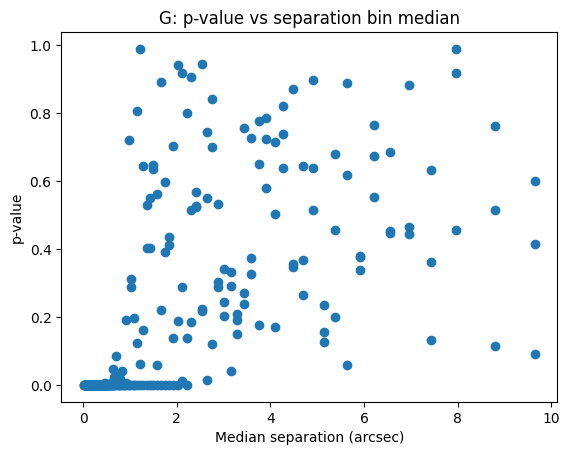

<Figure size 640x480 with 0 Axes>

In [194]:
# Plot p-values vs separation
plt.scatter(ks_test_results_df['med_sep'], ks_test_results_df['pvalue'])
plt.xlabel('Median separation (arcsec)')
plt.ylabel('p-value')
plt.title('G: p-value vs separation bin median')
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/GMean/pvalue_vs_separation_bin_median_aggregate_gmean.png')

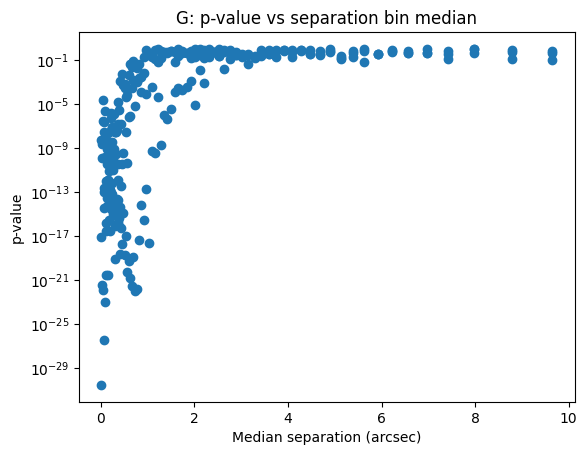

<Figure size 640x480 with 0 Axes>

In [195]:
# Plot p-values vs separation
plt.scatter(ks_test_results_df['med_sep'], ks_test_results_df['pvalue'])
plt.xlabel('Median separation (arcsec)')
plt.ylabel('p-value')
plt.title('G: p-value vs separation bin median')
plt.yscale("log")
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/GMean/log_pvalue_vs_separation_bin_median_aggregate_gmean.png')

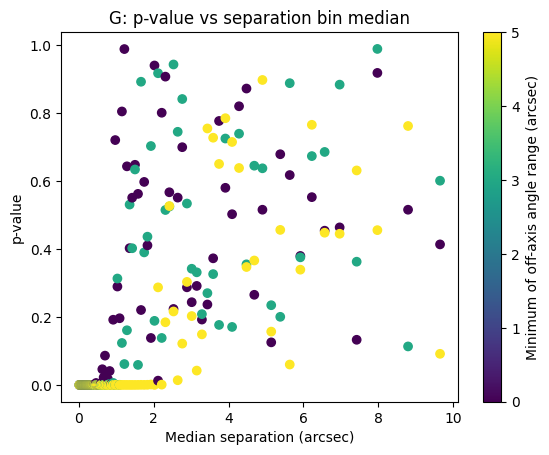

<Figure size 640x480 with 0 Axes>

In [196]:
# Plot p-values vs separation with title and color by off-axis angle
plt.scatter(ks_test_results_df['med_sep'], ks_test_results_df['pvalue'], c=ks_test_results_df['min_offaxis'])
plt.xlabel('Median separation (arcsec)')
plt.ylabel('p-value')
plt.title('G: p-value vs separation bin median')
plt.colorbar(label='Minimum of off-axis angle range (arcsec)')
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/GMean/pvalue_vs_separation_bin_median_color_offaxis_aggregate_gmean.png')

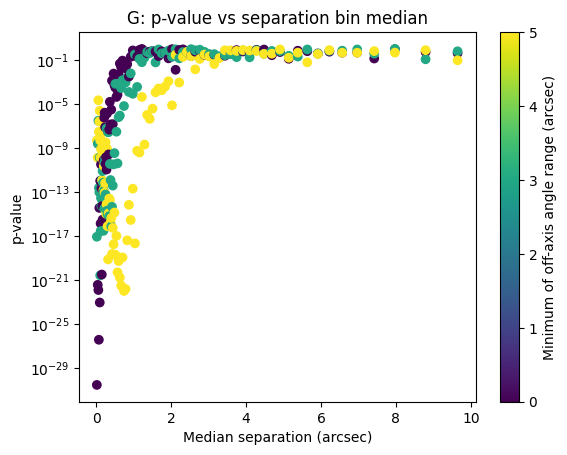

<Figure size 640x480 with 0 Axes>

In [197]:
# Plot p-values vs separation with title and color by off-axis angle
plt.scatter(ks_test_results_df['med_sep'], ks_test_results_df['pvalue'], c=ks_test_results_df['min_offaxis'])
plt.xlabel('Median separation (arcsec)')
plt.ylabel('p-value')
plt.title('G: p-value vs separation bin median')
plt.colorbar(label='Minimum of off-axis angle range (arcsec)')
plt.yscale("log")
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/GMean/log_pvalue_vs_separation_bin_median_color_offaxis_aggregate_gmean.png')

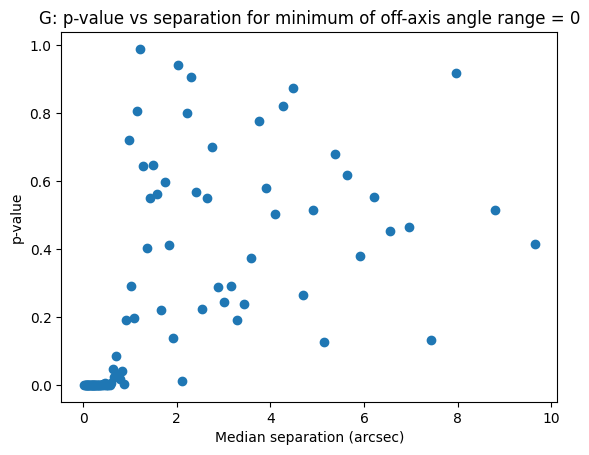

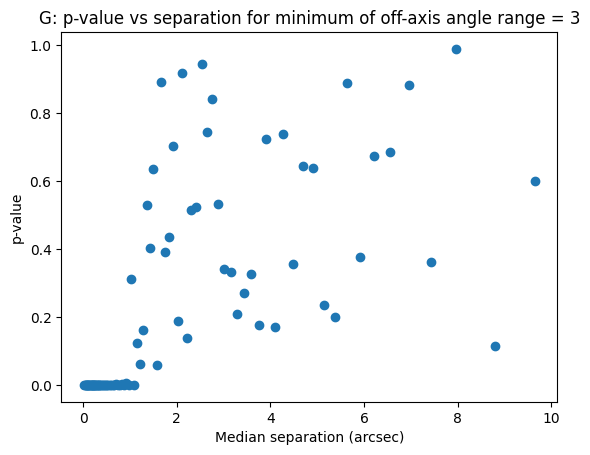

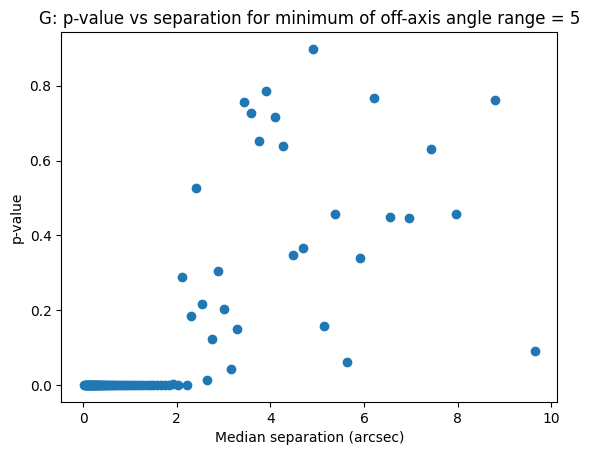

<Figure size 640x480 with 0 Axes>

In [198]:
# Plot p-values vs separation with title for each off-axis angle
for i in [0, 3, 5]:
    plt.scatter(ks_test_results_df[ks_test_results_df['min_offaxis'] == i]['med_sep'], 
                ks_test_results_df[ks_test_results_df['min_offaxis'] == i]['pvalue'])
    plt.xlabel('Median separation (arcsec)')
    plt.ylabel('p-value')
    plt.title('G: p-value vs separation for minimum of off-axis angle range = ' + str(i))
    plt.show()
    plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/GMean/pvalue_vs_separation_bin_median_min_offaxis_' + str(i) + '_aggregate_gmean.png')

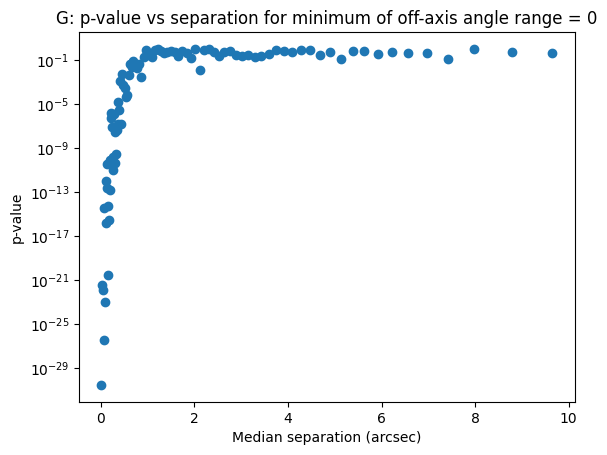

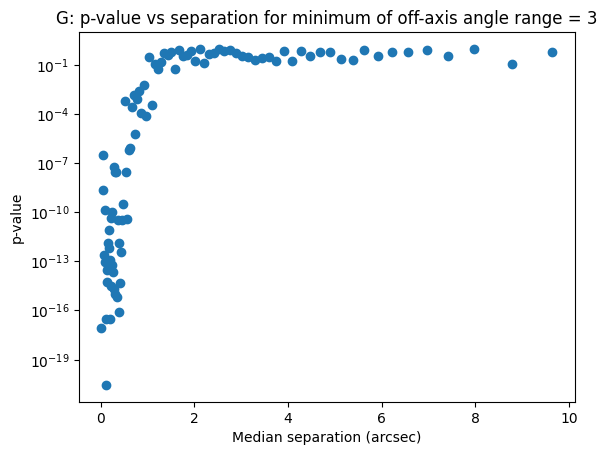

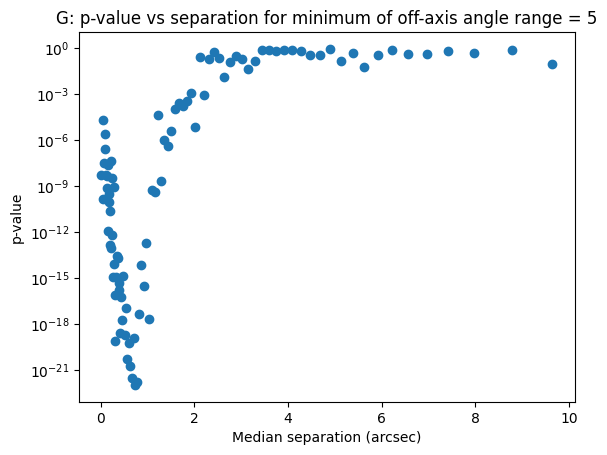

<Figure size 640x480 with 0 Axes>

In [199]:
# Plot p-values vs separation with title for each off-axis angle
for i in [0, 3, 5]:
    plt.scatter(ks_test_results_df[ks_test_results_df['min_offaxis'] == i]['med_sep'], 
                ks_test_results_df[ks_test_results_df['min_offaxis'] == i]['pvalue'])
    plt.xlabel('Median separation (arcsec)')
    plt.ylabel('p-value')
    plt.title('G: p-value vs separation for minimum of off-axis angle range = ' + str(i))
    plt.yscale("log")
    plt.show()
    plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/GMean/log_pvalue_vs_separation_bin_median_min_offaxis_' + str(i) + '_aggregate_gmean.png')

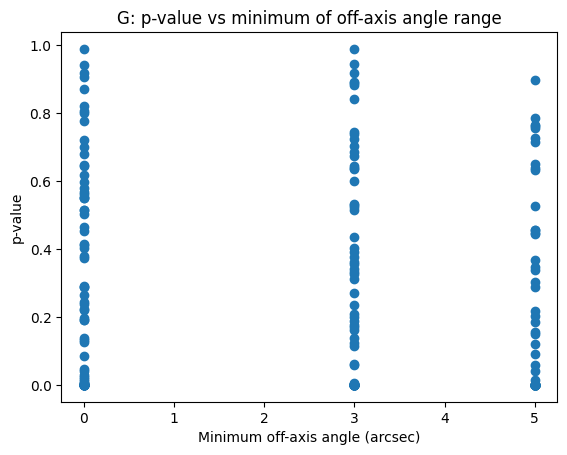

<Figure size 640x480 with 0 Axes>

In [200]:
# Plot p-values vs off-axis angle
plt.scatter(ks_test_results_df['min_offaxis'], ks_test_results_df['pvalue'])
plt.xlabel('Minimum off-axis angle (arcsec)')
plt.ylabel('p-value')
plt.title('G: p-value vs minimum of off-axis angle range')
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/GMean/pvalue_vs_minimum_offaxis_aggregate_gmean.png')

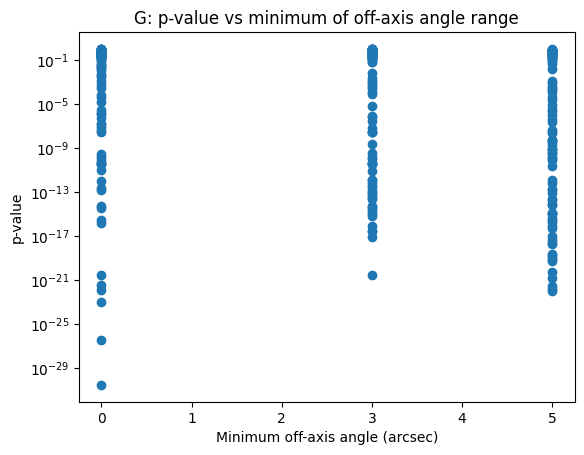

<Figure size 640x480 with 0 Axes>

In [201]:
# Plot p-values vs off-axis angle
plt.scatter(ks_test_results_df['min_offaxis'], ks_test_results_df['pvalue'])
plt.xlabel('Minimum off-axis angle (arcsec)')
plt.ylabel('p-value')
plt.title('G: p-value vs minimum of off-axis angle range')
plt.yscale("log")
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/GMean/log_pvalue_vs_minimum_offaxis_aggregate_gmean.png')

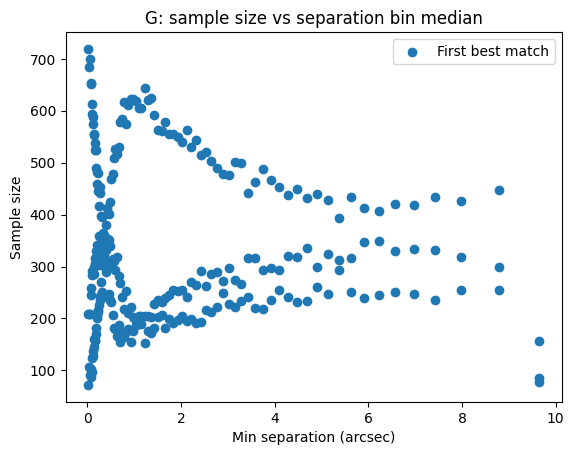

<Figure size 640x480 with 0 Axes>

In [202]:
# Plot sample size vs separation
plt.scatter(ks_test_results_df['med_sep'], ks_test_results_df['n_first'], label='First best match')
plt.xlabel('Min separation (arcsec)')
plt.ylabel('Sample size')
plt.title('G: sample size vs separation bin median')
plt.legend()
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/GMean/sample_size_min_separation_gmean.png')

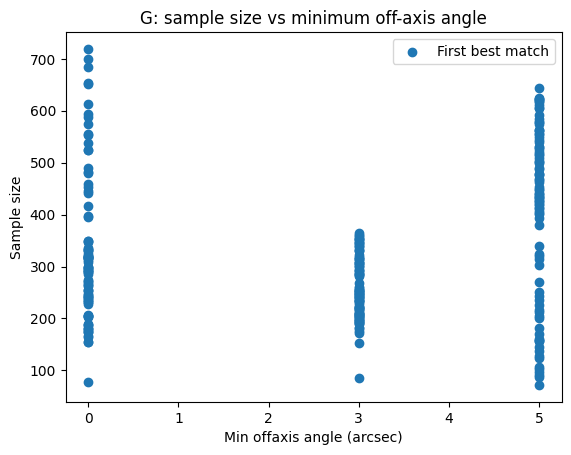

<Figure size 640x480 with 0 Axes>

In [203]:
# Plot sample size vs offaxis angle
plt.scatter(ks_test_results_df['min_offaxis'], ks_test_results_df['n_first'], label='First best match')
plt.xlabel('Min offaxis angle (arcsec)')
plt.ylabel('Sample size')
plt.title('G: sample size vs minimum off-axis angle')
plt.legend()
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/GMean/sample_size_min_offaxis_gmean.png')

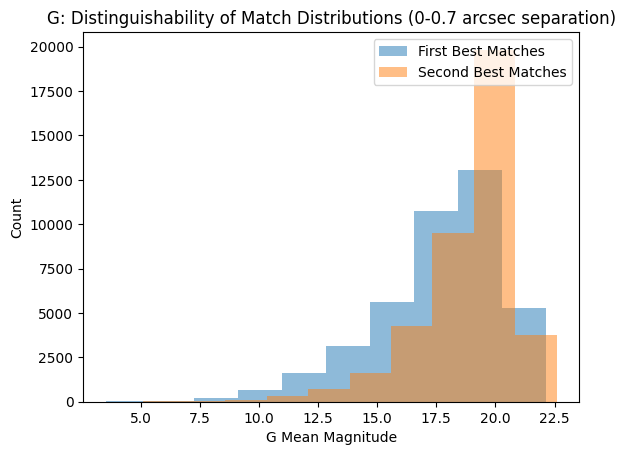

<Figure size 640x480 with 0 Axes>

In [204]:
# comparing distributions (first vs second best matches) with high distinguishability
data_first_match = first_match[(first_match["dist_arcsec"] > 0) & (first_match["dist_arcsec"] < 0.7)]
data_second_match = second_match[second_match["chandra_source_id"].isin(data_first_match["chandra_source_id"])]

plt.hist(data_first_match["phot_g_mean_mag"], alpha = 0.5, label = "First Best Matches")
plt.hist(data_second_match["phot_g_mean_mag"], alpha = 0.5, label = "Second Best Matches")
plt.legend(loc = "upper right")
plt.xlabel("G Mean Magnitude")
plt.ylabel("Count")
plt.title("G: Distinguishability of Match Distributions (0-0.7 arcsec separation)")
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/GMean/high_distinguishability_distributions_gmean.png')


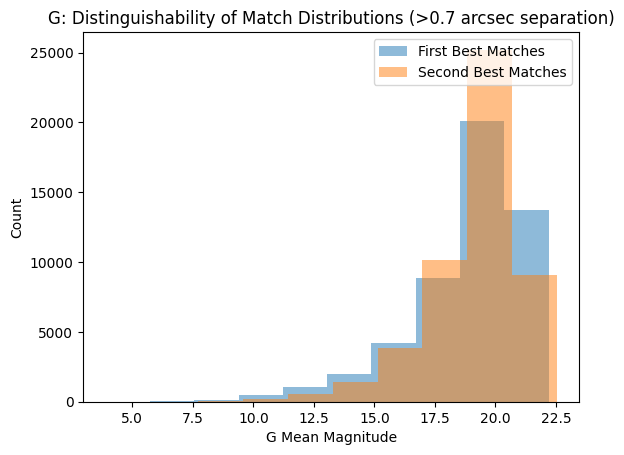

<Figure size 640x480 with 0 Axes>

In [205]:
# comparing distributions (first vs second best matches) with low distinguishability
data_first_match = first_match[(first_match["dist_arcsec"] > 0.7) & (first_match["dist_arcsec"] < float("inf"))]
data_second_match = second_match[second_match["chandra_source_id"].isin(data_first_match["chandra_source_id"])]

plt.hist(data_first_match["phot_g_mean_mag"], alpha = 0.5, label = "First Best Matches")
plt.hist(data_second_match["phot_g_mean_mag"], alpha = 0.5, label = "Second Best Matches")
plt.legend(loc = "upper right")
plt.xlabel("G Mean Magnitude")
plt.ylabel("Count")
plt.title("G: Distinguishability of Match Distributions (>0.7 arcsec separation)")
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/GMean/low_distinguishability_distributions_gmean.png')

### BP Mean Magnitude

In [206]:
variable = "phot_bp_mean_mag"
filter_column1 = "dist_arcsec"
filter_column2 = "min_theta_mean"
filter_count = "first"
unique_id = "chandra_source_id"

# filter 1 and 2 range (separation)
filter1 = bin_edges[:-1]
filter2 = bin_edges[1:]

# filter 3 and 4 range (off-axis angle)
filter3 = [0, 3, 5]
filter4 = [3, 5, float("inf")] #

# KS test results
data = []

for i in range(len(filter1)):
    for j in range(len(filter3)):
        ks_test_results = ut.ks_test_filter_ranges(first_match, second_match, variable, filter_column1, filter_column2, 
                                                     filter1[i], filter2[i], filter3[j], filter4[j],
                                                     unique_id = unique_id, filter_count = filter_count)
        
        data.append({'statistic': ks_test_results[0], 'pvalue': ks_test_results[1], 
                                   'min_sep': filter1[i], 'max_sep': filter2[i], 'med_sep': (filter1[i] + filter2[i])/2,
                                   'min_offaxis': filter3[j], 'max_offaxis': filter4[j], 
                                   'filter_by': filter_count, 'n_first': ks_test_results[2], 'n_second': ks_test_results[3]})
        
ks_test_results_df = pd.DataFrame(data)

ks_test_results_df.to_csv("/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/data/processed_data/BPmean_ks_test_results.csv", index = False)

print(ks_test_results_df.head())

   statistic        pvalue   min_sep   max_sep   med_sep  min_offaxis  \
0   0.285118  3.798676e-26  0.000000  0.030257  0.015129            0   
1   0.397129  4.177352e-15  0.000000  0.030257  0.015129            3   
2   0.500000  1.521907e-08  0.000000  0.030257  0.015129            5   
3   0.235036  5.303041e-17  0.030257  0.048175  0.039216            0   
4   0.320574  6.758245e-10  0.030257  0.048175  0.039216            3   

   max_offaxis filter_by  n_first  n_second  
0          3.0     first      719       719  
1          5.0     first      209       209  
2          inf     first       72        72  
3          3.0     first      685       685  
4          5.0     first      209       209  


#### Thresholds

In [207]:
# Overall
overall_sep_01 = ks_test_results_df[ks_test_results_df["pvalue"] > 0.01].max_sep.min()
overall_sep_05 = ks_test_results_df[ks_test_results_df["pvalue"] > 0.05].max_sep.min()
overall_sep_10 = ks_test_results_df[ks_test_results_df["pvalue"] > 0.10].max_sep.min()

# 0-3 arcmin off-axis angle
offaxis_0_sep_01 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.01) & (ks_test_results_df["min_offaxis"] == 0)].max_sep.min()
offaxis_0_sep_05 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.05) & (ks_test_results_df["min_offaxis"] == 0)].max_sep.min()
offaxis_0_sep_10 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.10) & (ks_test_results_df["min_offaxis"] == 0)].max_sep.min()

# 3-5 arcmin off-axis angle
offaxis_3_sep_01 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.01) & (ks_test_results_df["min_offaxis"] == 3)].max_sep.min()
offaxis_3_sep_05 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.05) & (ks_test_results_df["min_offaxis"] == 3)].max_sep.min()
offaxis_3_sep_10 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.10) & (ks_test_results_df["min_offaxis"] == 3)].max_sep.min()

# >5 arcmin off-axis angle
offaxis_5_sep_01 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.01) & (ks_test_results_df["min_offaxis"] == 5)].max_sep.min()
offaxis_5_sep_05 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.05) & (ks_test_results_df["min_offaxis"] == 5)].max_sep.min()
offaxis_5_sep_10 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.10) & (ks_test_results_df["min_offaxis"] == 5)].max_sep.min()

thresholds = [{"sig_lvl": 0.01, "offaxis_stratif": "overall", "sep_threshold": overall_sep_01},
              {"sig_lvl": 0.05, "offaxis_stratif": "overall", "sep_threshold": overall_sep_05},
              {"sig_lvl": 0.10, "offaxis_stratif": "overall", "sep_threshold": overall_sep_10},
              {"sig_lvl": 0.01, "offaxis_stratif": "0-3", "sep_threshold": offaxis_0_sep_01},
              {"sig_lvl": 0.05, "offaxis_stratif": "0-3", "sep_threshold": offaxis_0_sep_05},
              {"sig_lvl": 0.10, "offaxis_stratif": "0-3", "sep_threshold": offaxis_0_sep_10},
              {"sig_lvl": 0.01, "offaxis_stratif": "3-5", "sep_threshold": offaxis_3_sep_01},
              {"sig_lvl": 0.05, "offaxis_stratif": "3-5", "sep_threshold": offaxis_3_sep_05},
              {"sig_lvl": 0.10, "offaxis_stratif": "3-5", "sep_threshold": offaxis_3_sep_10},
              {"sig_lvl": 0.01, "offaxis_stratif": ">5", "sep_threshold": offaxis_5_sep_01},
              {"sig_lvl": 0.05, "offaxis_stratif": ">5", "sep_threshold": offaxis_5_sep_05},
              {"sig_lvl": 0.10, "offaxis_stratif": ">5", "sep_threshold": offaxis_5_sep_10}]

thresholds = pd.DataFrame(thresholds)

thresholds.to_csv("/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/data/processed_data/BPmean_separation_thresholds.csv", index = False)

print(thresholds)

    sig_lvl offaxis_stratif  sep_threshold
0      0.01         overall       0.497129
1      0.05         overall       0.612642
2      0.10         overall       0.646228
3      0.01             0-3       0.497129
4      0.05             0-3       0.612642
5      0.10             0-3       0.646228
6      0.01             3-5       0.803920
7      0.05             3-5       1.061833
8      0.10             3-5       1.061833
9      0.01              >5       2.165748
10     0.05              >5       2.165748
11     0.10              >5       2.165748


#### Plots

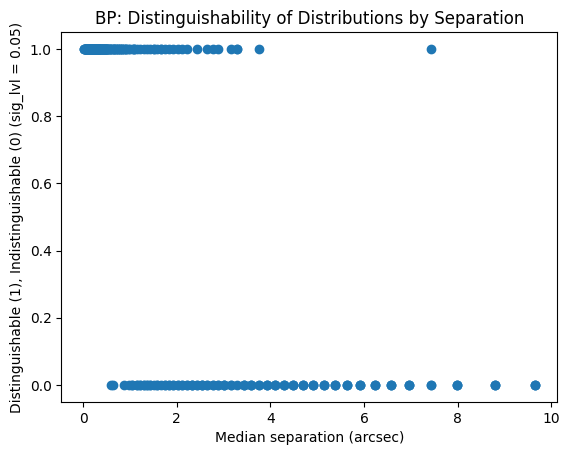

<Figure size 640x480 with 0 Axes>

In [208]:
# Make p-values binary (0.05)
ks_test_results_df['pvalue_binary'] = ks_test_results_df['pvalue'].apply(lambda x: 1 if x < 0.05 else 0)

# Plot binary y axis for p-values vs separation
plt.plot(ks_test_results_df['med_sep'], ks_test_results_df['pvalue_binary'], 'o')
plt.xlabel('Median separation (arcsec)')
plt.ylabel('Distinguishable (1), Indistinguishable (0) (sig_lvl = 0.05)')
plt.title('BP: Distinguishability of Distributions by Separation')
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/BPMean/binary_pvalue_vs_median_separation_aggregate_bpmean.png')

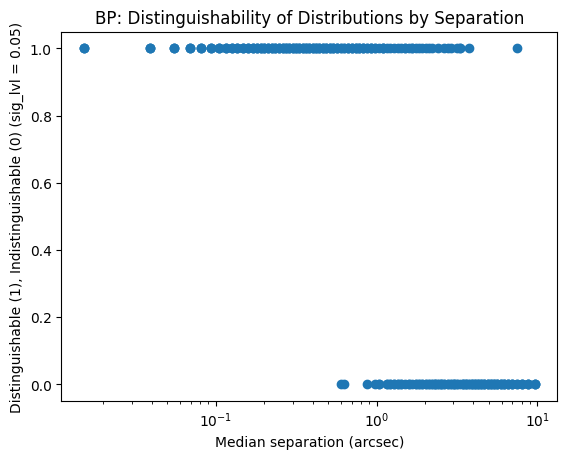

<Figure size 640x480 with 0 Axes>

In [209]:
# Plot binary y axis for p-values vs separation
plt.plot(ks_test_results_df['med_sep'], ks_test_results_df['pvalue_binary'], 'o')
plt.xlabel('Median separation (arcsec)')
plt.ylabel('Distinguishable (1), Indistinguishable (0) (sig_lvl = 0.05)')
plt.title('BP: Distinguishability of Distributions by Separation')
plt.xscale('log')
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/BPMean/binary_pvalue_vs_log_median_separation_aggregate_bpmean.png')

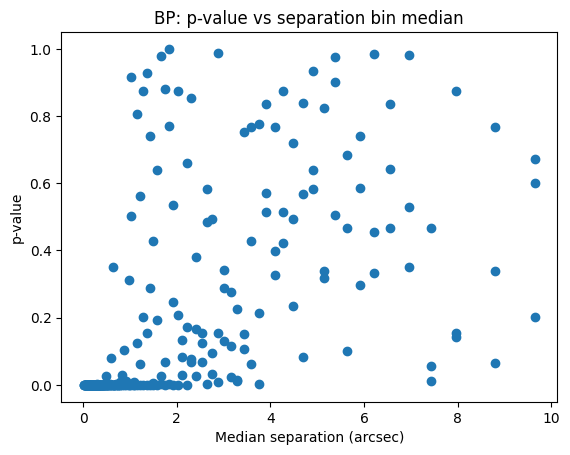

<Figure size 640x480 with 0 Axes>

In [210]:
# Plot p-values vs separation
plt.scatter(ks_test_results_df['med_sep'], ks_test_results_df['pvalue'])
plt.xlabel('Median separation (arcsec)')
plt.ylabel('p-value')
plt.title('BP: p-value vs separation bin median')
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/BPMean/pvalue_vs_separation_bin_median_aggregate_bpmean.png')

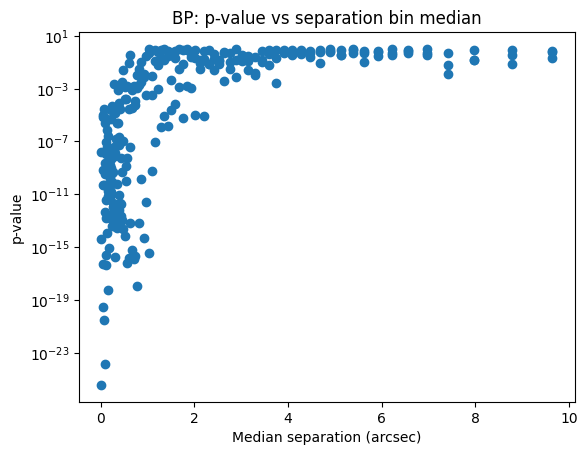

<Figure size 640x480 with 0 Axes>

In [211]:
# Plot p-values vs separation
plt.scatter(ks_test_results_df['med_sep'], ks_test_results_df['pvalue'])
plt.xlabel('Median separation (arcsec)')
plt.ylabel('p-value')
plt.title('BP: p-value vs separation bin median')
plt.yscale("log")
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/BPMean/log_pvalue_vs_separation_bin_median_aggregate_bpmean.png')

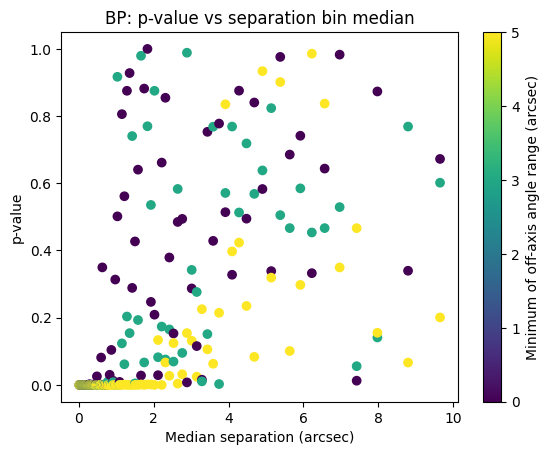

<Figure size 640x480 with 0 Axes>

In [212]:
# Plot p-values vs separation with title and color by off-axis angle
plt.scatter(ks_test_results_df['med_sep'], ks_test_results_df['pvalue'], c=ks_test_results_df['min_offaxis'])
plt.xlabel('Median separation (arcsec)')
plt.ylabel('p-value')
plt.title('BP: p-value vs separation bin median')
plt.colorbar(label='Minimum of off-axis angle range (arcsec)')
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/BPMean/pvalue_vs_separation_bin_median_color_offaxis_aggregate_bpmean.png')

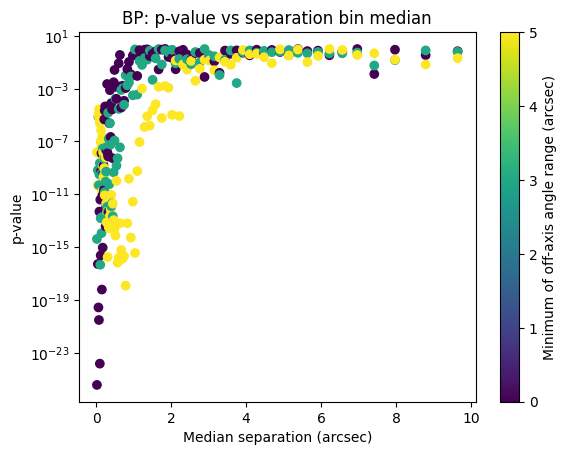

<Figure size 640x480 with 0 Axes>

In [213]:
# Plot p-values vs separation with title and color by off-axis angle
plt.scatter(ks_test_results_df['med_sep'], ks_test_results_df['pvalue'], c=ks_test_results_df['min_offaxis'])
plt.xlabel('Median separation (arcsec)')
plt.ylabel('p-value')
plt.title('BP: p-value vs separation bin median')
plt.colorbar(label='Minimum of off-axis angle range (arcsec)')
plt.yscale("log")
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/BPMean/log_pvalue_vs_separation_bin_median_color_offaxis_aggregate_bpmean.png')

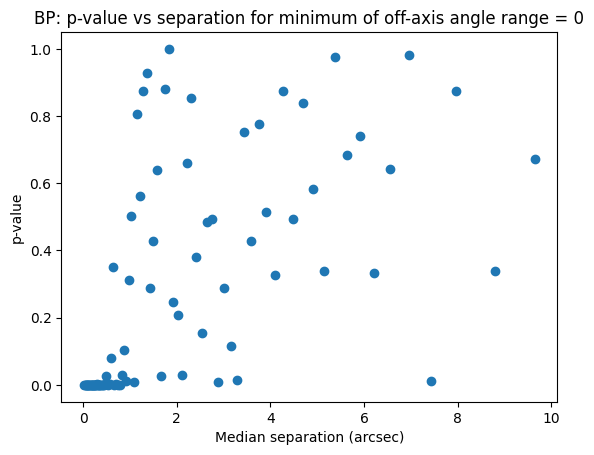

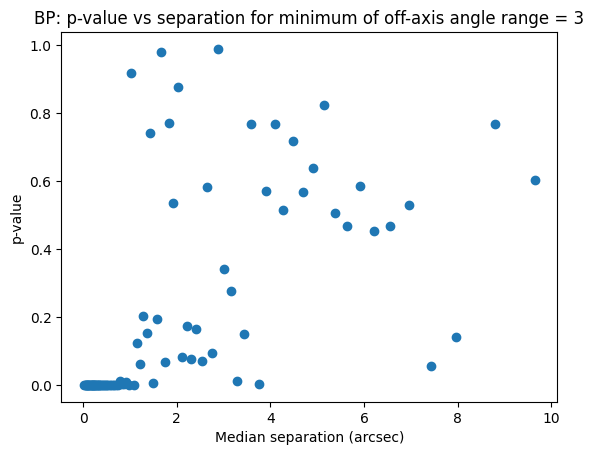

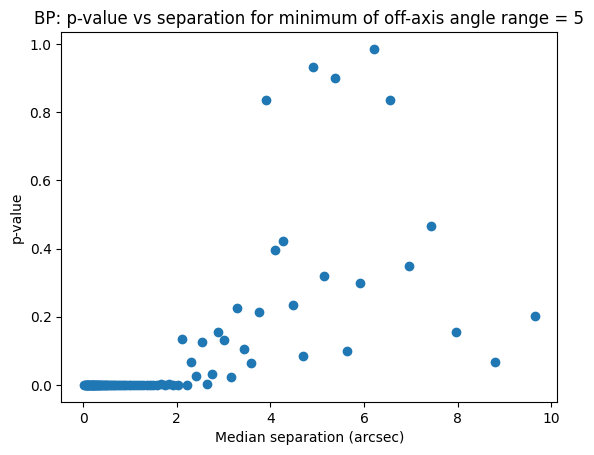

<Figure size 640x480 with 0 Axes>

In [214]:
# Plot p-values vs separation with title for each off-axis angle
for i in [0, 3, 5]:
    plt.scatter(ks_test_results_df[ks_test_results_df['min_offaxis'] == i]['med_sep'], 
                ks_test_results_df[ks_test_results_df['min_offaxis'] == i]['pvalue'])
    plt.xlabel('Median separation (arcsec)')
    plt.ylabel('p-value')
    plt.title('BP: p-value vs separation for minimum of off-axis angle range = ' + str(i))
    plt.show()
    plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/BPMean/pvalue_vs_separation_bin_median_min_offaxis_' + str(i) + '_aggregate_bpmean.png')

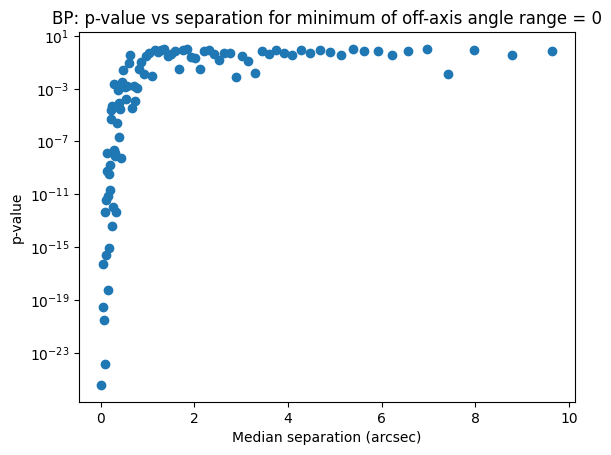

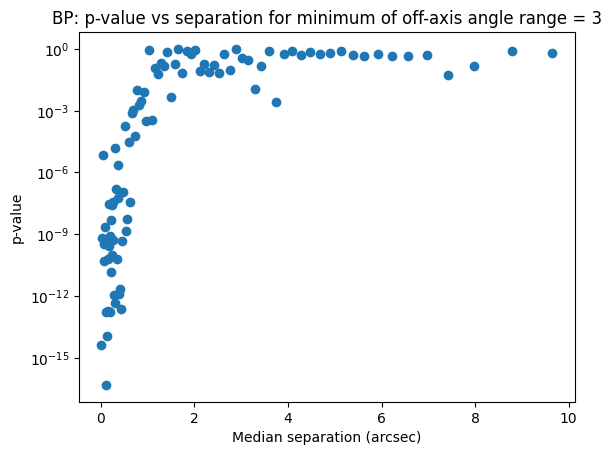

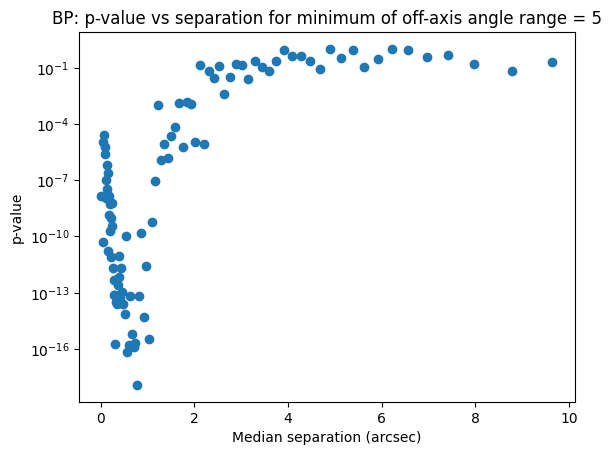

<Figure size 640x480 with 0 Axes>

In [215]:
# Plot p-values vs separation with title for each off-axis angle
for i in [0, 3, 5]:
    plt.scatter(ks_test_results_df[ks_test_results_df['min_offaxis'] == i]['med_sep'], 
                ks_test_results_df[ks_test_results_df['min_offaxis'] == i]['pvalue'])
    plt.xlabel('Median separation (arcsec)')
    plt.ylabel('p-value')
    plt.title('BP: p-value vs separation for minimum of off-axis angle range = ' + str(i))
    plt.yscale("log")
    plt.show()
    plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/BPMean/log_pvalue_vs_separation_bin_median_min_offaxis_' + str(i) + '_aggregate_bpmean.png')

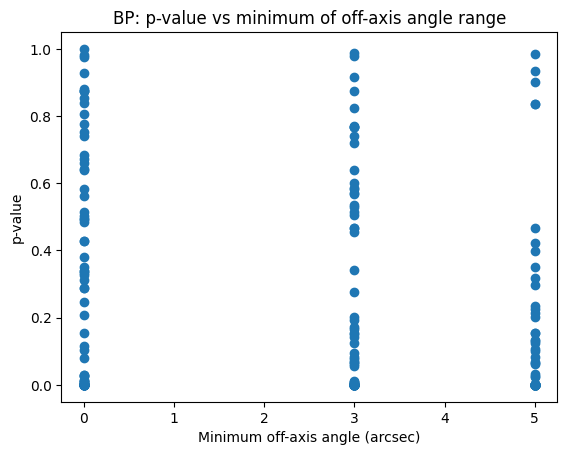

<Figure size 640x480 with 0 Axes>

In [216]:
# Plot p-values vs off-axis angle
plt.scatter(ks_test_results_df['min_offaxis'], ks_test_results_df['pvalue'])
plt.xlabel('Minimum off-axis angle (arcsec)')
plt.ylabel('p-value')
plt.title('BP: p-value vs minimum of off-axis angle range')
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/BPMean/pvalue_vs_minimum_offaxis_aggregate_bpmean.png')

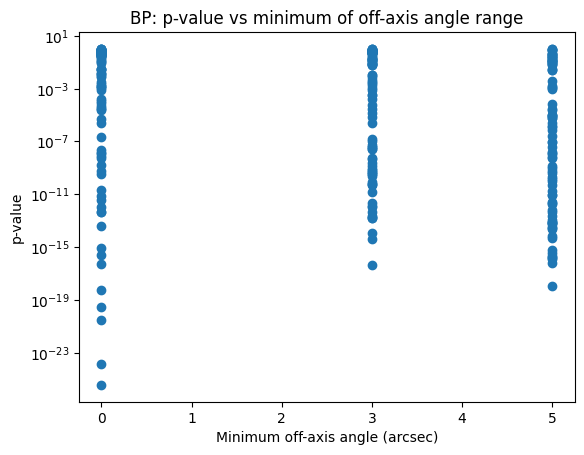

<Figure size 640x480 with 0 Axes>

In [217]:
# Plot p-values vs off-axis angle
plt.scatter(ks_test_results_df['min_offaxis'], ks_test_results_df['pvalue'])
plt.xlabel('Minimum off-axis angle (arcsec)')
plt.ylabel('p-value')
plt.title('BP: p-value vs minimum of off-axis angle range')
plt.yscale("log")
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/BPMean/log_pvalue_vs_minimum_offaxis_aggregate_bpmean.png')

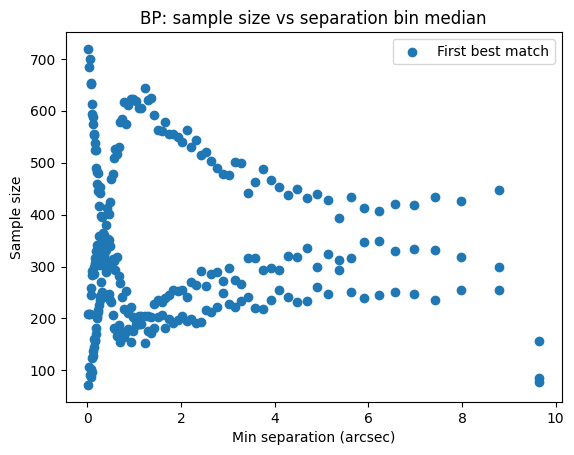

<Figure size 640x480 with 0 Axes>

In [218]:
# Plot sample size vs separation
plt.scatter(ks_test_results_df['med_sep'], ks_test_results_df['n_first'], label='First best match')
plt.xlabel('Min separation (arcsec)')
plt.ylabel('Sample size')
plt.title('BP: sample size vs separation bin median')
plt.legend()
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/BPMean/sample_size_min_separation_bpmean.png')

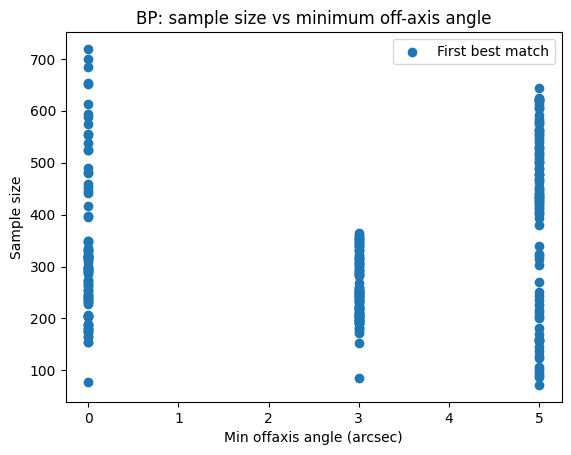

<Figure size 640x480 with 0 Axes>

In [219]:
# Plot sample size vs offaxis angle
plt.scatter(ks_test_results_df['min_offaxis'], ks_test_results_df['n_first'], label='First best match')
plt.xlabel('Min offaxis angle (arcsec)')
plt.ylabel('Sample size')
plt.title('BP: sample size vs minimum off-axis angle')
plt.legend()
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/BPMean/sample_size_min_offaxis_bpmean.png')

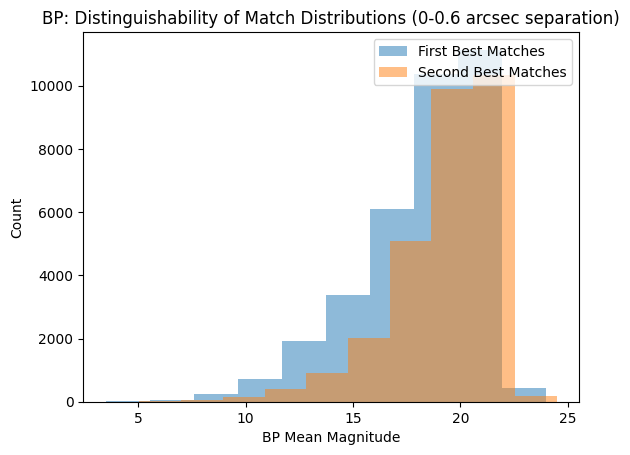

<Figure size 640x480 with 0 Axes>

In [220]:
# comparing distributions (first vs second best matches) with high distinguishability
data_first_match = first_match[(first_match["dist_arcsec"] > 0) & (first_match["dist_arcsec"] < 0.6)]
data_second_match = second_match[second_match["chandra_source_id"].isin(data_first_match["chandra_source_id"])]

plt.hist(data_first_match["phot_bp_mean_mag"], alpha = 0.5, label = "First Best Matches")
plt.hist(data_second_match["phot_bp_mean_mag"], alpha = 0.5, label = "Second Best Matches")
plt.legend(loc = "upper right")
plt.xlabel("BP Mean Magnitude")
plt.ylabel("Count")
plt.title("BP: Distinguishability of Match Distributions (0-0.6 arcsec separation)")
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/BPMean/high_distinguishability_distributions_bpmean.png')

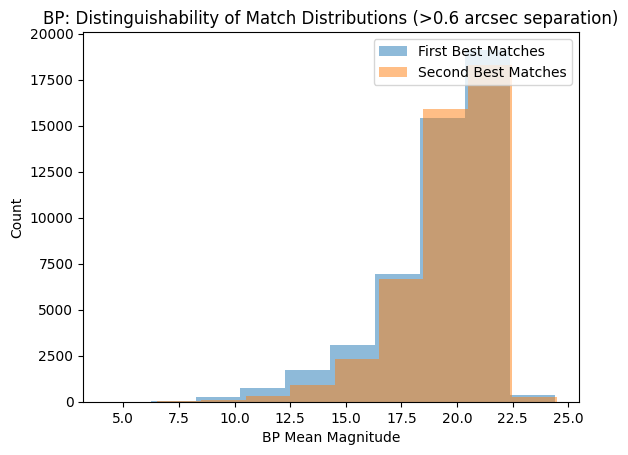

<Figure size 640x480 with 0 Axes>

In [221]:
# comparing distributions (first vs second best matches) with low distinguishability
data_first_match = first_match[(first_match["dist_arcsec"] > 0.6) & (first_match["dist_arcsec"] < float("inf"))]
data_second_match = second_match[second_match["chandra_source_id"].isin(data_first_match["chandra_source_id"])]

plt.hist(data_first_match["phot_bp_mean_mag"], alpha = 0.5, label = "First Best Matches")
plt.hist(data_second_match["phot_bp_mean_mag"], alpha = 0.5, label = "Second Best Matches")
plt.legend(loc = "upper right")
plt.xlabel("BP Mean Magnitude")
plt.ylabel("Count")
plt.title("BP: Distinguishability of Match Distributions (>0.6 arcsec separation)")
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/BPMean/low_distinguishability_distributions_bpmean.png')

### RP Mean Magnitude

In [222]:
variable = "phot_rp_mean_mag"
filter_column1 = "dist_arcsec"
filter_column2 = "min_theta_mean"
filter_count = "first"
unique_id = "chandra_source_id"

# filter 1 and 2 range (separation)
filter1 = bin_edges[:-1]
filter2 = bin_edges[1:]

# filter 3 and 4 range (off-axis angle)
filter3 = [0, 3, 5]
filter4 = [3, 5, float("inf")] #

# KS test results
data = []

for i in range(len(filter1)):
    for j in range(len(filter3)):
        ks_test_results = ut.ks_test_filter_ranges(first_match, second_match, variable, filter_column1, filter_column2, 
                                                     filter1[i], filter2[i], filter3[j], filter4[j],
                                                     unique_id = unique_id, filter_count = filter_count)
        
        data.append({'statistic': ks_test_results[0], 'pvalue': ks_test_results[1], 
                                   'min_sep': filter1[i], 'max_sep': filter2[i], 'med_sep': (filter1[i] + filter2[i])/2,
                                   'min_offaxis': filter3[j], 'max_offaxis': filter4[j], 
                                   'filter_by': filter_count, 'n_first': ks_test_results[2], 'n_second': ks_test_results[3]})
        
ks_test_results_df = pd.DataFrame(data)

ks_test_results_df.to_csv("/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/data/processed_data/RPmean_ks_test_results.csv", index = False)

print(ks_test_results_df.head())

   statistic        pvalue   min_sep   max_sep   med_sep  min_offaxis  \
0   0.329624  5.697982e-35  0.000000  0.030257  0.015129            0   
1   0.459330  2.912239e-20  0.000000  0.030257  0.015129            3   
2   0.541667  4.898865e-10  0.000000  0.030257  0.015129            5   
3   0.300730  9.906977e-28  0.030257  0.048175  0.039216            0   
4   0.358852  2.385666e-12  0.030257  0.048175  0.039216            3   

   max_offaxis filter_by  n_first  n_second  
0          3.0     first      719       719  
1          5.0     first      209       209  
2          inf     first       72        72  
3          3.0     first      685       685  
4          5.0     first      209       209  


#### Thresholds

In [223]:
# Overall
overall_sep_01 = ks_test_results_df[ks_test_results_df["pvalue"] > 0.01].max_sep.min()
overall_sep_05 = ks_test_results_df[ks_test_results_df["pvalue"] > 0.05].max_sep.min()
overall_sep_10 = ks_test_results_df[ks_test_results_df["pvalue"] > 0.10].max_sep.min()

# 0-3 arcmin off-axis angle
offaxis_0_sep_01 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.01) & (ks_test_results_df["min_offaxis"] == 0)].max_sep.min()
offaxis_0_sep_05 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.05) & (ks_test_results_df["min_offaxis"] == 0)].max_sep.min()
offaxis_0_sep_10 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.10) & (ks_test_results_df["min_offaxis"] == 0)].max_sep.min()

# 3-5 arcmin off-axis angle
offaxis_3_sep_01 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.01) & (ks_test_results_df["min_offaxis"] == 3)].max_sep.min()
offaxis_3_sep_05 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.05) & (ks_test_results_df["min_offaxis"] == 3)].max_sep.min()
offaxis_3_sep_10 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.10) & (ks_test_results_df["min_offaxis"] == 3)].max_sep.min()

# >5 arcmin off-axis angle
offaxis_5_sep_01 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.01) & (ks_test_results_df["min_offaxis"] == 5)].max_sep.min()
offaxis_5_sep_05 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.05) & (ks_test_results_df["min_offaxis"] == 5)].max_sep.min()
offaxis_5_sep_10 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.10) & (ks_test_results_df["min_offaxis"] == 5)].max_sep.min()

thresholds = [{"sig_lvl": 0.01, "offaxis_stratif": "overall", "sep_threshold": overall_sep_01},
              {"sig_lvl": 0.05, "offaxis_stratif": "overall", "sep_threshold": overall_sep_05},
              {"sig_lvl": 0.10, "offaxis_stratif": "overall", "sep_threshold": overall_sep_10},
              {"sig_lvl": 0.01, "offaxis_stratif": "0-3", "sep_threshold": offaxis_0_sep_01},
              {"sig_lvl": 0.05, "offaxis_stratif": "0-3", "sep_threshold": offaxis_0_sep_05},
              {"sig_lvl": 0.10, "offaxis_stratif": "0-3", "sep_threshold": offaxis_0_sep_10},
              {"sig_lvl": 0.01, "offaxis_stratif": "3-5", "sep_threshold": offaxis_3_sep_01},
              {"sig_lvl": 0.05, "offaxis_stratif": "3-5", "sep_threshold": offaxis_3_sep_05},
              {"sig_lvl": 0.10, "offaxis_stratif": "3-5", "sep_threshold": offaxis_3_sep_10},
              {"sig_lvl": 0.01, "offaxis_stratif": ">5", "sep_threshold": offaxis_5_sep_01},
              {"sig_lvl": 0.05, "offaxis_stratif": ">5", "sep_threshold": offaxis_5_sep_05},
              {"sig_lvl": 0.10, "offaxis_stratif": ">5", "sep_threshold": offaxis_5_sep_10}]

thresholds = pd.DataFrame(thresholds)

thresholds.to_csv("/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/data/processed_data/RPmean_separation_thresholds.csv", index = False)

print(thresholds)

    sig_lvl offaxis_stratif  sep_threshold
0      0.01         overall       0.847309
1      0.05         overall       0.894024
2      0.10         overall       1.002792
3      0.01             0-3       0.847309
4      0.05             0-3       0.894024
5      0.10             0-3       1.002792
6      0.01             3-5       1.061833
7      0.05             3-5       1.061833
8      0.10             3-5       1.061833
9      0.01              >5       2.165748
10     0.05              >5       2.165748
11     0.10              >5       2.165748


#### Plots

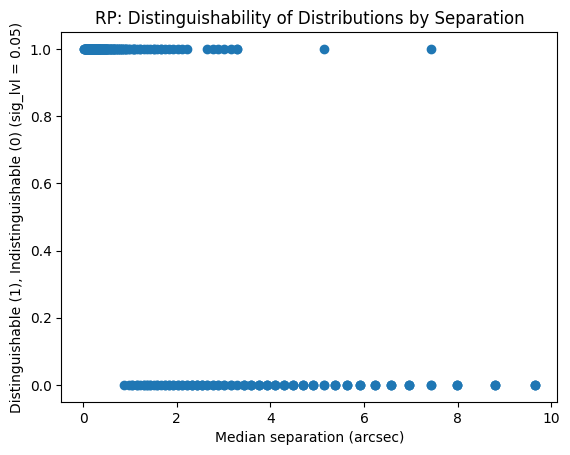

<Figure size 640x480 with 0 Axes>

In [224]:
# Make p-values binary (0.05)
ks_test_results_df['pvalue_binary'] = ks_test_results_df['pvalue'].apply(lambda x: 1 if x < 0.05 else 0)

# Plot binary y axis for p-values vs separation
plt.plot(ks_test_results_df['med_sep'], ks_test_results_df['pvalue_binary'], 'o')
plt.xlabel('Median separation (arcsec)')
plt.ylabel('Distinguishable (1), Indistinguishable (0) (sig_lvl = 0.05)')
plt.title('RP: Distinguishability of Distributions by Separation')
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/RPMean/binary_pvalue_vs_median_separation_aggregate_rpmean.png')

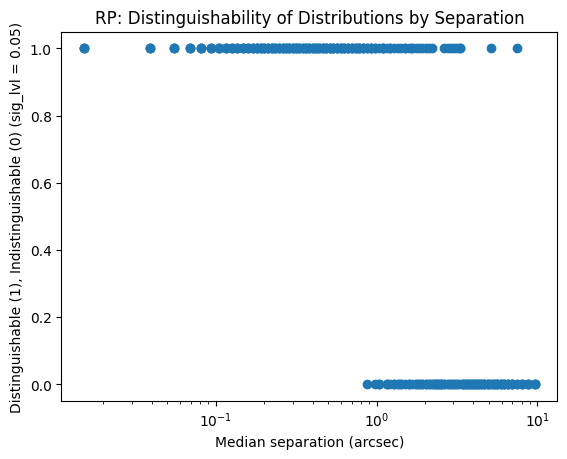

<Figure size 640x480 with 0 Axes>

In [225]:
# Plot binary y axis for p-values vs separation
plt.plot(ks_test_results_df['med_sep'], ks_test_results_df['pvalue_binary'], 'o')
plt.xlabel('Median separation (arcsec)')
plt.ylabel('Distinguishable (1), Indistinguishable (0) (sig_lvl = 0.05)')
plt.title('RP: Distinguishability of Distributions by Separation')
plt.xscale('log')
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/RPMean/binary_pvalue_vs_log_median_separation_aggregate_rpmean.png')

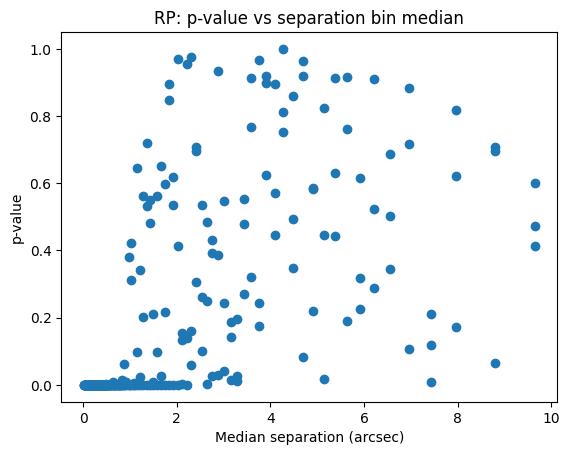

<Figure size 640x480 with 0 Axes>

In [226]:
# Plot p-values vs separation
plt.scatter(ks_test_results_df['med_sep'], ks_test_results_df['pvalue'])
plt.xlabel('Median separation (arcsec)')
plt.ylabel('p-value')
plt.title('RP: p-value vs separation bin median')
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/RPMean/pvalue_vs_separation_bin_median_aggregate_rpmean.png')

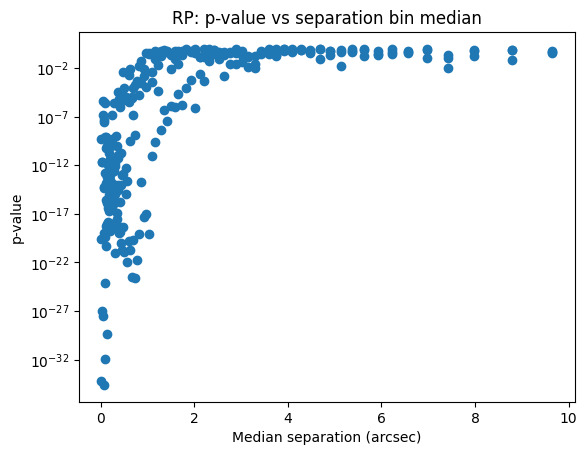

<Figure size 640x480 with 0 Axes>

In [227]:
# Plot p-values vs separation
plt.scatter(ks_test_results_df['med_sep'], ks_test_results_df['pvalue'])
plt.xlabel('Median separation (arcsec)')
plt.ylabel('p-value')
plt.title('RP: p-value vs separation bin median')
plt.yscale("log")
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/RPMean/log_pvalue_vs_separation_bin_median_aggregate_rpmean.png')

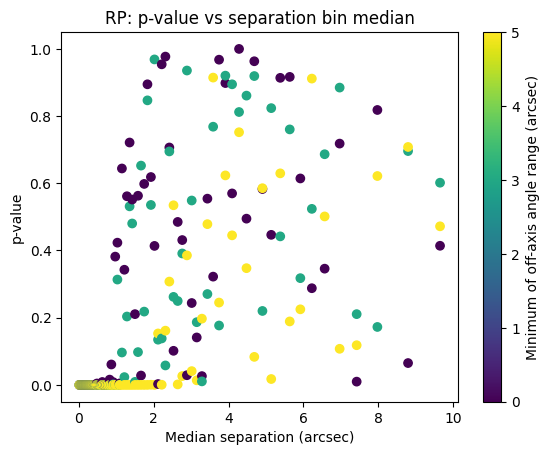

<Figure size 640x480 with 0 Axes>

In [228]:
# Plot p-values vs separation with title and color by off-axis angle
plt.scatter(ks_test_results_df['med_sep'], ks_test_results_df['pvalue'], c=ks_test_results_df['min_offaxis'])
plt.xlabel('Median separation (arcsec)')
plt.ylabel('p-value')
plt.title('RP: p-value vs separation bin median')
plt.colorbar(label='Minimum of off-axis angle range (arcsec)')
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/RPMean/pvalue_vs_separation_bin_median_color_offaxis_aggregate_rpmean.png')

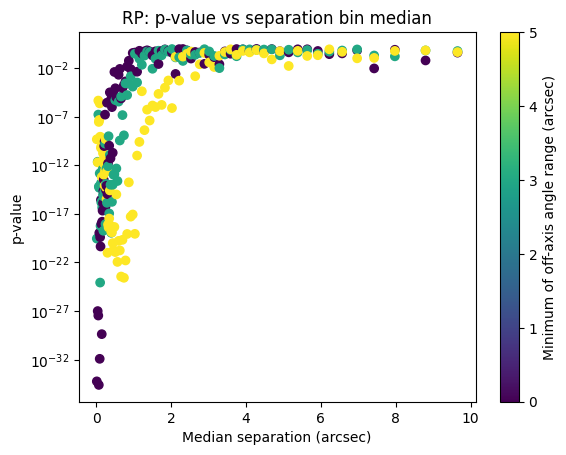

<Figure size 640x480 with 0 Axes>

In [229]:
# Plot p-values vs separation with title and color by off-axis angle
plt.scatter(ks_test_results_df['med_sep'], ks_test_results_df['pvalue'], c=ks_test_results_df['min_offaxis'])
plt.xlabel('Median separation (arcsec)')
plt.ylabel('p-value')
plt.title('RP: p-value vs separation bin median')
plt.colorbar(label='Minimum of off-axis angle range (arcsec)')
plt.yscale("log")
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/RPMean/log_pvalue_vs_separation_bin_median_color_offaxis_aggregate_rpmean.png')

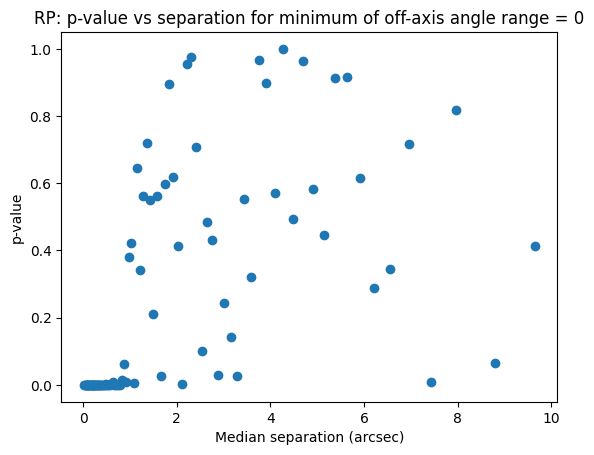

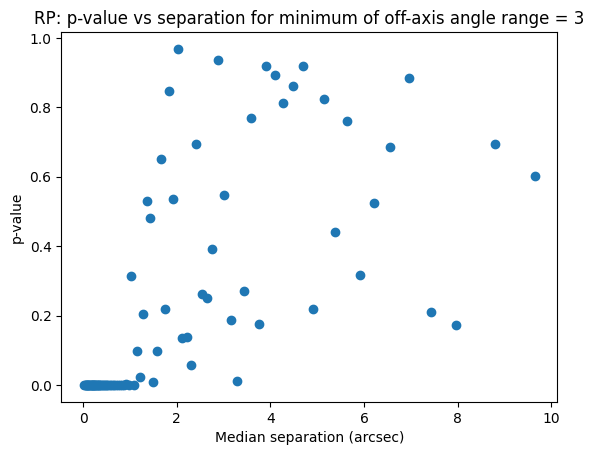

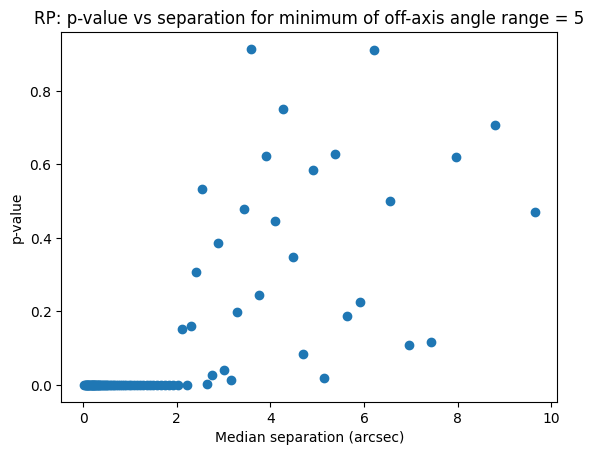

<Figure size 640x480 with 0 Axes>

In [230]:
# Plot p-values vs separation with title for each off-axis angle
for i in [0, 3, 5]:
    plt.scatter(ks_test_results_df[ks_test_results_df['min_offaxis'] == i]['med_sep'], 
                ks_test_results_df[ks_test_results_df['min_offaxis'] == i]['pvalue'])
    plt.xlabel('Median separation (arcsec)')
    plt.ylabel('p-value')
    plt.title('RP: p-value vs separation for minimum of off-axis angle range = ' + str(i))
    plt.show()
    plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/RPMean/pvalue_vs_separation_bin_median_min_offaxis_' + str(i) + '_aggregate_rpmean.png')

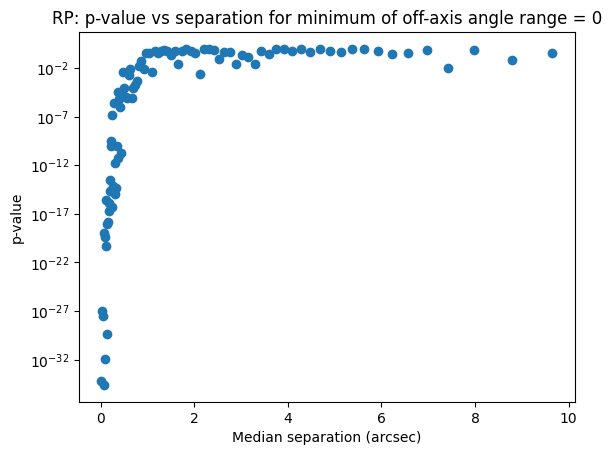

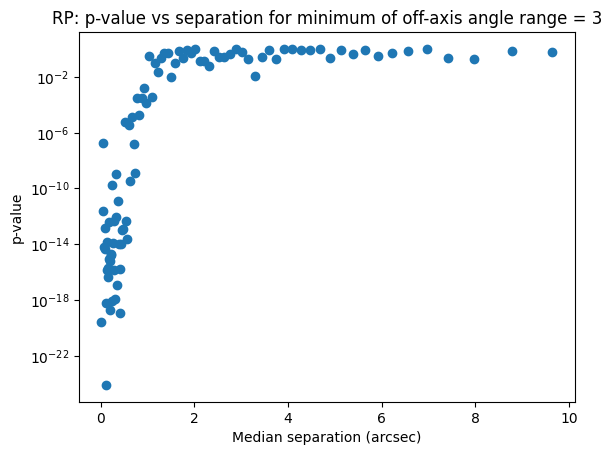

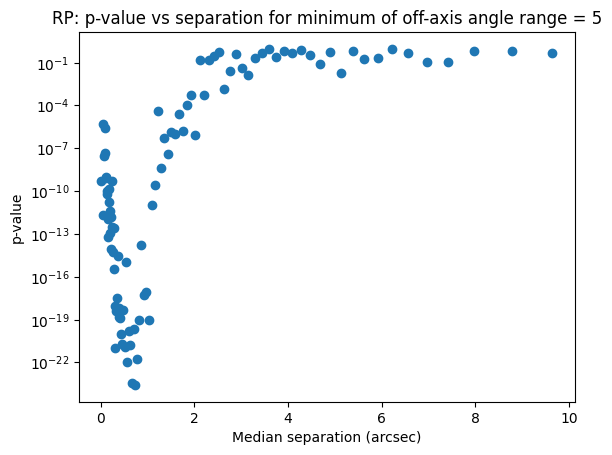

<Figure size 640x480 with 0 Axes>

In [231]:
# Plot p-values vs separation with title for each off-axis angle
for i in [0, 3, 5]:
    plt.scatter(ks_test_results_df[ks_test_results_df['min_offaxis'] == i]['med_sep'], 
                ks_test_results_df[ks_test_results_df['min_offaxis'] == i]['pvalue'])
    plt.xlabel('Median separation (arcsec)')
    plt.ylabel('p-value')
    plt.title('RP: p-value vs separation for minimum of off-axis angle range = ' + str(i))
    plt.yscale("log")
    plt.show()
    plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/RPMean/log_pvalue_vs_separation_bin_median_min_offaxis_' + str(i) + '_aggregate_rpmean.png')

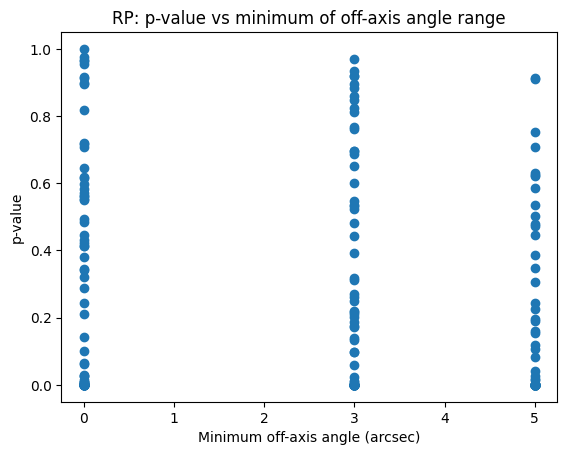

<Figure size 640x480 with 0 Axes>

In [232]:
# Plot p-values vs off-axis angle
plt.scatter(ks_test_results_df['min_offaxis'], ks_test_results_df['pvalue'])
plt.xlabel('Minimum off-axis angle (arcsec)')
plt.ylabel('p-value')
plt.title('RP: p-value vs minimum of off-axis angle range')
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/RPMean/pvalue_vs_minimum_offaxis_aggregate_rpmean.png')

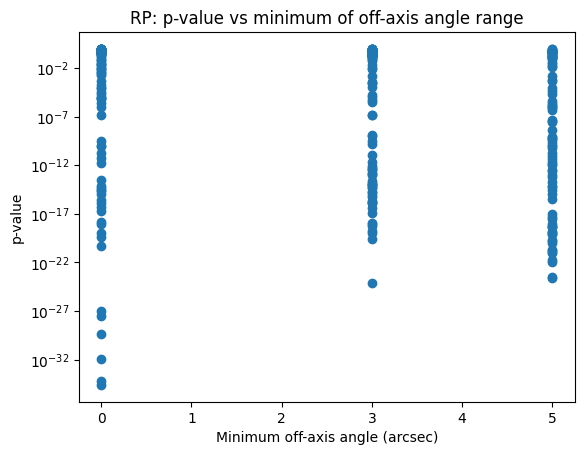

<Figure size 640x480 with 0 Axes>

In [233]:
# Plot p-values vs off-axis angle
plt.scatter(ks_test_results_df['min_offaxis'], ks_test_results_df['pvalue'])
plt.xlabel('Minimum off-axis angle (arcsec)')
plt.ylabel('p-value')
plt.title('RP: p-value vs minimum of off-axis angle range')
plt.yscale("log")
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/RPMean/log_pvalue_vs_minimum_offaxis_aggregate_rpmean.png')

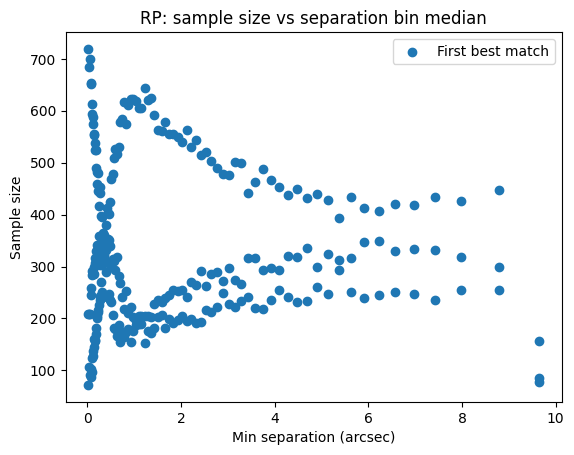

<Figure size 640x480 with 0 Axes>

In [234]:
# Plot sample size vs separation
plt.scatter(ks_test_results_df['med_sep'], ks_test_results_df['n_first'], label='First best match')
plt.xlabel('Min separation (arcsec)')
plt.ylabel('Sample size')
plt.title('RP: sample size vs separation bin median')
plt.legend()
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/RPMean/sample_size_min_separation_rpmean.png')

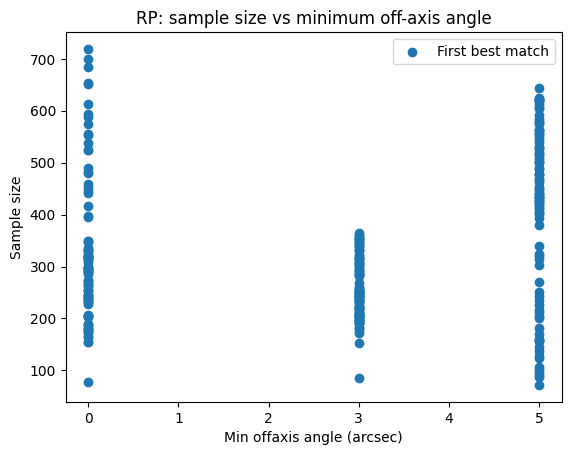

<Figure size 640x480 with 0 Axes>

In [235]:
# Plot sample size vs offaxis angle
plt.scatter(ks_test_results_df['min_offaxis'], ks_test_results_df['n_first'], label='First best match')
plt.xlabel('Min offaxis angle (arcsec)')
plt.ylabel('Sample size')
plt.title('RP: sample size vs minimum off-axis angle')
plt.legend()
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/RPMean/sample_size_min_offaxis_rpmean.png')

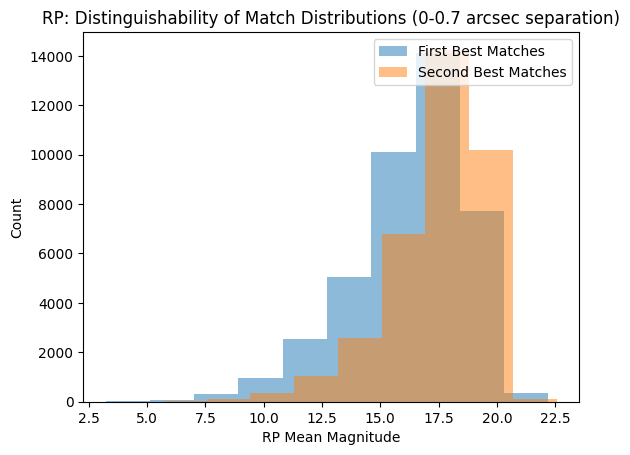

<Figure size 640x480 with 0 Axes>

In [236]:
# comparing distributions (first vs second best matches) with high distinguishability
data_first_match = first_match[(first_match["dist_arcsec"] > 0) & (first_match["dist_arcsec"] < 0.9)]
data_second_match = second_match[second_match["chandra_source_id"].isin(data_first_match["chandra_source_id"])]

plt.hist(data_first_match["phot_rp_mean_mag"], alpha = 0.5, label = "First Best Matches")
plt.hist(data_second_match["phot_rp_mean_mag"], alpha = 0.5, label = "Second Best Matches")
plt.legend(loc = "upper right")
plt.xlabel("RP Mean Magnitude")
plt.ylabel("Count")
plt.title("RP: Distinguishability of Match Distributions (0-0.7 arcsec separation)")
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/RPMean/high_distinguishability_distributions_rpmean.png')

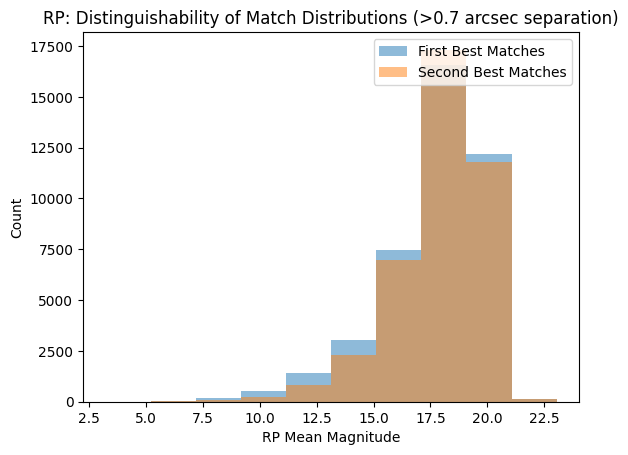

<Figure size 640x480 with 0 Axes>

In [237]:
# comparing distributions (first vs second best matches) with low distinguishability
data_first_match = first_match[(first_match["dist_arcsec"] > 0.9) & (first_match["dist_arcsec"] < float("inf"))]
data_second_match = second_match[second_match["chandra_source_id"].isin(data_first_match["chandra_source_id"])]

plt.hist(data_first_match["phot_rp_mean_mag"], alpha = 0.5, label = "First Best Matches")
plt.hist(data_second_match["phot_rp_mean_mag"], alpha = 0.5, label = "Second Best Matches")
plt.legend(loc = "upper right")
plt.xlabel("RP Mean Magnitude")
plt.ylabel("Count")
plt.title("RP: Distinguishability of Match Distributions (>0.7 arcsec separation)")
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/RPMean/low_distinguishability_distributions_rpmean.png')

## Results - First- and Last-Best Match Distributions

### G Mean Magnitude

In [238]:
variable = "phot_g_mean_mag"
filter_column1 = "dist_arcsec"
filter_column2 = "min_theta_mean"
filter_count = "first"
unique_id = "chandra_source_id"

# filter 1 and 2 range (separation)
filter1 = bin_edges[:-1]
filter2 = bin_edges[1:]

# filter 3 and 4 range (off-axis angle)
filter3 = [0, 3, 5]
filter4 = [3, 5, float("inf")] #

# KS test results
data = []

for i in range(len(filter1)):
    for j in range(len(filter3)):
        ks_test_results = ut.ks_test_filter_ranges(first_match, last_match, variable, filter_column1, filter_column2, 
                                                     filter1[i], filter2[i], filter3[j], filter4[j],
                                                     unique_id = unique_id, filter_count = filter_count)
        
        data.append({'statistic': ks_test_results[0], 'pvalue': ks_test_results[1], 
                                   'min_sep': filter1[i], 'max_sep': filter2[i], 'med_sep': (filter1[i] + filter2[i])/2,
                                   'min_offaxis': filter3[j], 'max_offaxis': filter4[j], 
                                   'filter_by': filter_count, 'n_first': ks_test_results[2], 'n_second': ks_test_results[3]})
        
ks_test_results_df = pd.DataFrame(data)

ks_test_results_df.to_csv("/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/data/processed_data/Gmean_ks_test_results_last_match.csv", index = False)

print(ks_test_results_df.head())

   statistic        pvalue   min_sep   max_sep   med_sep  min_offaxis  \
0   0.331015  2.869830e-35  0.000000  0.030257  0.015129            0   
1   0.416268  1.334073e-16  0.000000  0.030257  0.015129            3   
2   0.611111  7.249085e-13  0.000000  0.030257  0.015129            5   
3   0.328467  4.223004e-33  0.030257  0.048175  0.039216            0   
4   0.349282  1.044339e-11  0.030257  0.048175  0.039216            3   

   max_offaxis filter_by  n_first  n_second  
0          3.0     first      719       719  
1          5.0     first      209       209  
2          inf     first       72        72  
3          3.0     first      685       685  
4          5.0     first      209       209  


#### Thresholds

In [239]:
# Overall
overall_sep_01 = ks_test_results_df[ks_test_results_df["pvalue"] > 0.01].max_sep.min()
overall_sep_05 = ks_test_results_df[ks_test_results_df["pvalue"] > 0.05].max_sep.min()
overall_sep_10 = ks_test_results_df[ks_test_results_df["pvalue"] > 0.10].max_sep.min()

# 0-3 arcmin off-axis angle
offaxis_0_sep_01 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.01) & (ks_test_results_df["min_offaxis"] == 0)].max_sep.min()
offaxis_0_sep_05 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.05) & (ks_test_results_df["min_offaxis"] == 0)].max_sep.min()
offaxis_0_sep_10 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.10) & (ks_test_results_df["min_offaxis"] == 0)].max_sep.min()

# 3-5 arcmin off-axis angle
offaxis_3_sep_01 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.01) & (ks_test_results_df["min_offaxis"] == 3)].max_sep.min()
offaxis_3_sep_05 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.05) & (ks_test_results_df["min_offaxis"] == 3)].max_sep.min()
offaxis_3_sep_10 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.10) & (ks_test_results_df["min_offaxis"] == 3)].max_sep.min()

# >5 arcmin off-axis angle
offaxis_5_sep_01 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.01) & (ks_test_results_df["min_offaxis"] == 5)].max_sep.min()
offaxis_5_sep_05 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.05) & (ks_test_results_df["min_offaxis"] == 5)].max_sep.min()
offaxis_5_sep_10 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.10) & (ks_test_results_df["min_offaxis"] == 5)].max_sep.min()

thresholds = [{"sig_lvl": 0.01, "offaxis_stratif": "overall", "sep_threshold": overall_sep_01},
              {"sig_lvl": 0.05, "offaxis_stratif": "overall", "sep_threshold": overall_sep_05},
              {"sig_lvl": 0.10, "offaxis_stratif": "overall", "sep_threshold": overall_sep_10},
              {"sig_lvl": 0.01, "offaxis_stratif": "0-3", "sep_threshold": offaxis_0_sep_01},
              {"sig_lvl": 0.05, "offaxis_stratif": "0-3", "sep_threshold": offaxis_0_sep_05},
              {"sig_lvl": 0.10, "offaxis_stratif": "0-3", "sep_threshold": offaxis_0_sep_10},
              {"sig_lvl": 0.01, "offaxis_stratif": "3-5", "sep_threshold": offaxis_3_sep_01},
              {"sig_lvl": 0.05, "offaxis_stratif": "3-5", "sep_threshold": offaxis_3_sep_05},
              {"sig_lvl": 0.10, "offaxis_stratif": "3-5", "sep_threshold": offaxis_3_sep_10},
              {"sig_lvl": 0.01, "offaxis_stratif": ">5", "sep_threshold": offaxis_5_sep_01},
              {"sig_lvl": 0.05, "offaxis_stratif": ">5", "sep_threshold": offaxis_5_sep_05},
              {"sig_lvl": 0.10, "offaxis_stratif": ">5", "sep_threshold": offaxis_5_sep_10}]

thresholds = pd.DataFrame(thresholds)

thresholds.to_csv("/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/data/processed_data/Gmean_separation_thresholds_last_match.csv", index = False)

print(thresholds)

    sig_lvl offaxis_stratif  sep_threshold
0      0.01         overall       0.646228
1      0.05         overall       0.847309
2      0.10         overall       0.847309
3      0.01             0-3       0.646228
4      0.05             0-3       0.847309
5      0.10             0-3       0.847309
6      0.01             3-5       1.250916
7      0.05             3-5       1.250916
8      0.10             3-5       1.250916
9      0.01              >5       2.362926
10     0.05              >5       2.585526
11     0.10              >5       2.585526


#### Plots

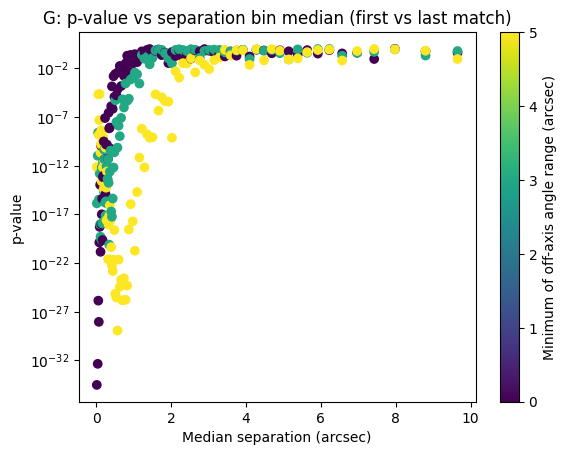

<Figure size 640x480 with 0 Axes>

In [240]:
# Plot p-values vs separation with title and color by off-axis angle
plt.scatter(ks_test_results_df['med_sep'], ks_test_results_df['pvalue'], c=ks_test_results_df['min_offaxis'])
plt.xlabel('Median separation (arcsec)')
plt.ylabel('p-value')
plt.title('G: p-value vs separation bin median (first vs last match)')
plt.colorbar(label='Minimum of off-axis angle range (arcsec)')
plt.yscale("log")
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/GMean/log_pvalue_vs_separation_bin_median_color_offaxis_aggregate_gmean_last_match.png')

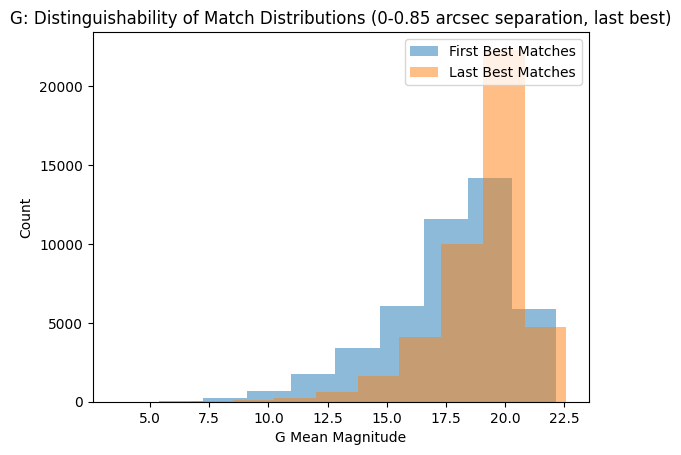

<Figure size 640x480 with 0 Axes>

In [241]:
# comparing distributions (first vs second best matches) with high distinguishability
data_first_match = first_match[(first_match["dist_arcsec"] > 0) & (first_match["dist_arcsec"] < 0.85)]
data_last_match = last_match[last_match["chandra_source_id"].isin(data_first_match["chandra_source_id"])]

plt.hist(data_first_match["phot_g_mean_mag"], alpha = 0.5, label = "First Best Matches")
plt.hist(data_last_match["phot_g_mean_mag"], alpha = 0.5, label = "Last Best Matches")
plt.legend(loc = "upper right")
plt.xlabel("G Mean Magnitude")
plt.ylabel("Count")
plt.title("G: Distinguishability of Match Distributions (0-0.85 arcsec separation, last best)")
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/GMean/high_distinguishability_distributions_gmean_last_match.png')

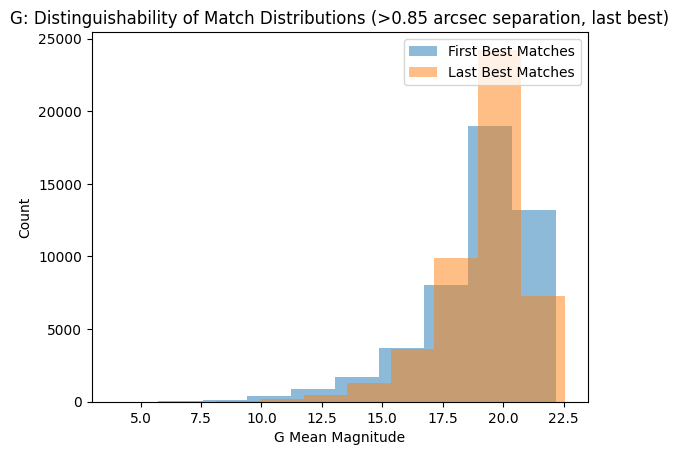

<Figure size 640x480 with 0 Axes>

In [242]:
# comparing distributions (first vs second best matches) with low distinguishability
data_first_match = first_match[(first_match["dist_arcsec"] > 0.85) & (first_match["dist_arcsec"] < float("inf"))]
data_last_match = last_match[last_match["chandra_source_id"].isin(data_first_match["chandra_source_id"])]

plt.hist(data_first_match["phot_g_mean_mag"], alpha = 0.5, label = "First Best Matches")
plt.hist(data_last_match["phot_g_mean_mag"], alpha = 0.5, label = "Last Best Matches")
plt.legend(loc = "upper right")
plt.xlabel("G Mean Magnitude")
plt.ylabel("Count")
plt.title("G: Distinguishability of Match Distributions (>0.85 arcsec separation, last best)")
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/GMean/low_distinguishability_distributions_gmean_last_match.png')

### BP Mean Magnitude

In [243]:
variable = "phot_bp_mean_mag"
filter_column1 = "dist_arcsec"
filter_column2 = "min_theta_mean"
filter_count = "first"
unique_id = "chandra_source_id"

# filter 1 and 2 range (separation)
filter1 = bin_edges[:-1]
filter2 = bin_edges[1:]

# filter 3 and 4 range (off-axis angle)
filter3 = [0, 3, 5]
filter4 = [3, 5, float("inf")] #

# KS test results
data = []

for i in range(len(filter1)):
    for j in range(len(filter3)):
        ks_test_results = ut.ks_test_filter_ranges(first_match, last_match, variable, filter_column1, filter_column2, 
                                                     filter1[i], filter2[i], filter3[j], filter4[j],
                                                     unique_id = unique_id, filter_count = filter_count)
        
        data.append({'statistic': ks_test_results[0], 'pvalue': ks_test_results[1], 
                                   'min_sep': filter1[i], 'max_sep': filter2[i], 'med_sep': (filter1[i] + filter2[i])/2,
                                   'min_offaxis': filter3[j], 'max_offaxis': filter4[j], 
                                   'filter_by': filter_count, 'n_first': ks_test_results[2], 'n_second': ks_test_results[3]})
        
ks_test_results_df = pd.DataFrame(data)

ks_test_results_df.to_csv("/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/data/processed_data/BPmean_ks_test_results_last_match.csv", index = False)

print(ks_test_results_df.head())

   statistic        pvalue   min_sep   max_sep   med_sep  min_offaxis  \
0   0.317107  2.375382e-32  0.000000  0.030257  0.015129            0   
1   0.387560  2.183550e-14  0.000000  0.030257  0.015129            3   
2   0.583333  1.111526e-11  0.000000  0.030257  0.015129            5   
3   0.270073  2.222279e-22  0.030257  0.048175  0.039216            0   
4   0.325359  3.464516e-10  0.030257  0.048175  0.039216            3   

   max_offaxis filter_by  n_first  n_second  
0          3.0     first      719       719  
1          5.0     first      209       209  
2          inf     first       72        72  
3          3.0     first      685       685  
4          5.0     first      209       209  


#### Thresholds

In [244]:
# Overall
overall_sep_01 = ks_test_results_df[ks_test_results_df["pvalue"] > 0.01].max_sep.min()
overall_sep_05 = ks_test_results_df[ks_test_results_df["pvalue"] > 0.05].max_sep.min()
overall_sep_10 = ks_test_results_df[ks_test_results_df["pvalue"] > 0.10].max_sep.min()

# 0-3 arcmin off-axis angle
offaxis_0_sep_01 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.01) & (ks_test_results_df["min_offaxis"] == 0)].max_sep.min()
offaxis_0_sep_05 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.05) & (ks_test_results_df["min_offaxis"] == 0)].max_sep.min()
offaxis_0_sep_10 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.10) & (ks_test_results_df["min_offaxis"] == 0)].max_sep.min()

# 3-5 arcmin off-axis angle
offaxis_3_sep_01 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.01) & (ks_test_results_df["min_offaxis"] == 3)].max_sep.min()
offaxis_3_sep_05 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.05) & (ks_test_results_df["min_offaxis"] == 3)].max_sep.min()
offaxis_3_sep_10 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.10) & (ks_test_results_df["min_offaxis"] == 3)].max_sep.min()

# >5 arcmin off-axis angle
offaxis_5_sep_01 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.01) & (ks_test_results_df["min_offaxis"] == 5)].max_sep.min()
offaxis_5_sep_05 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.05) & (ks_test_results_df["min_offaxis"] == 5)].max_sep.min()
offaxis_5_sep_10 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.10) & (ks_test_results_df["min_offaxis"] == 5)].max_sep.min()

thresholds = [{"sig_lvl": 0.01, "offaxis_stratif": "overall", "sep_threshold": overall_sep_01},
              {"sig_lvl": 0.05, "offaxis_stratif": "overall", "sep_threshold": overall_sep_05},
              {"sig_lvl": 0.10, "offaxis_stratif": "overall", "sep_threshold": overall_sep_10},
              {"sig_lvl": 0.01, "offaxis_stratif": "0-3", "sep_threshold": offaxis_0_sep_01},
              {"sig_lvl": 0.05, "offaxis_stratif": "0-3", "sep_threshold": offaxis_0_sep_05},
              {"sig_lvl": 0.10, "offaxis_stratif": "0-3", "sep_threshold": offaxis_0_sep_10},
              {"sig_lvl": 0.01, "offaxis_stratif": "3-5", "sep_threshold": offaxis_3_sep_01},
              {"sig_lvl": 0.05, "offaxis_stratif": "3-5", "sep_threshold": offaxis_3_sep_05},
              {"sig_lvl": 0.10, "offaxis_stratif": "3-5", "sep_threshold": offaxis_3_sep_10},
              {"sig_lvl": 0.01, "offaxis_stratif": ">5", "sep_threshold": offaxis_5_sep_01},
              {"sig_lvl": 0.05, "offaxis_stratif": ">5", "sep_threshold": offaxis_5_sep_05},
              {"sig_lvl": 0.10, "offaxis_stratif": ">5", "sep_threshold": offaxis_5_sep_10}]

thresholds = pd.DataFrame(thresholds)

thresholds.to_csv("/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/data/processed_data/BPmean_separation_thresholds_last_match.csv", index = False)

print(thresholds)

    sig_lvl offaxis_stratif  sep_threshold
0      0.01         overall       0.472888
1      0.05         overall       0.612642
2      0.10         overall       0.646228
3      0.01             0-3       0.472888
4      0.05             0-3       0.612642
5      0.10             0-3       0.646228
6      0.01             3-5       1.002792
7      0.05             3-5       1.323753
8      0.10             3-5       1.460921
9      0.01              >5       2.165748
10     0.05              >5       2.585526
11     0.10              >5       2.585526


#### Plots

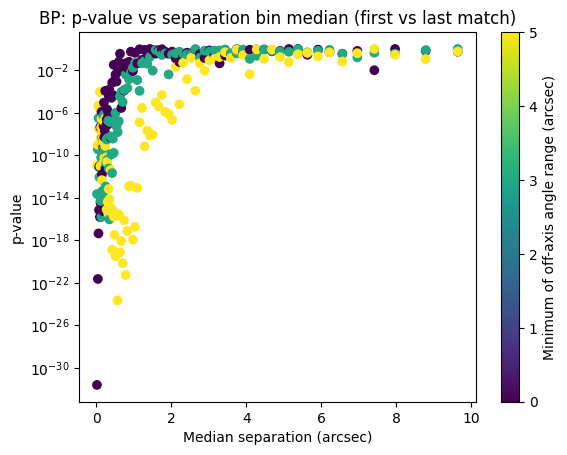

<Figure size 640x480 with 0 Axes>

In [245]:
# Plot p-values vs separation with title and color by off-axis angle
plt.scatter(ks_test_results_df['med_sep'], ks_test_results_df['pvalue'], c=ks_test_results_df['min_offaxis'])
plt.xlabel('Median separation (arcsec)')
plt.ylabel('p-value')
plt.title('BP: p-value vs separation bin median (first vs last match)')
plt.colorbar(label='Minimum of off-axis angle range (arcsec)')
plt.yscale("log")
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/BPMean/log_pvalue_vs_separation_bin_median_color_offaxis_aggregate_bpmean_last_match.png')

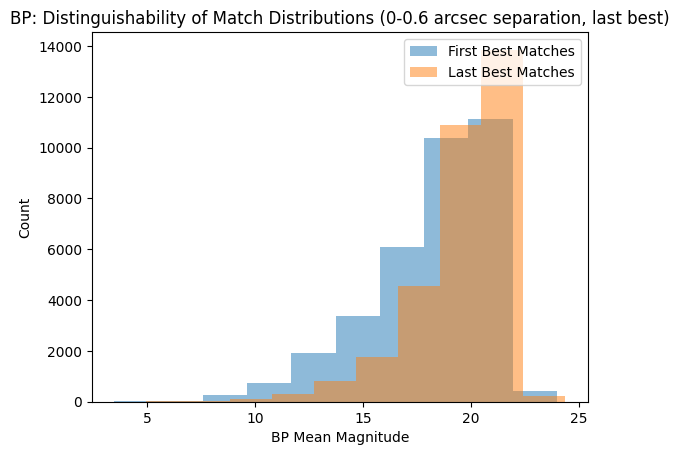

<Figure size 640x480 with 0 Axes>

In [246]:
# comparing distributions (first vs second best matches) with high distinguishability
data_first_match = first_match[(first_match["dist_arcsec"] > 0) & (first_match["dist_arcsec"] < 0.6)]
data_last_match = last_match[last_match["chandra_source_id"].isin(data_first_match["chandra_source_id"])]

plt.hist(data_first_match["phot_bp_mean_mag"], alpha = 0.5, label = "First Best Matches")
plt.hist(data_last_match["phot_bp_mean_mag"], alpha = 0.5, label = "Last Best Matches")
plt.legend(loc = "upper right")
plt.xlabel("BP Mean Magnitude")
plt.ylabel("Count")
plt.title("BP: Distinguishability of Match Distributions (0-0.6 arcsec separation, last best)")
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/BPMean/high_distinguishability_distributions_bpmean_last_match.png')

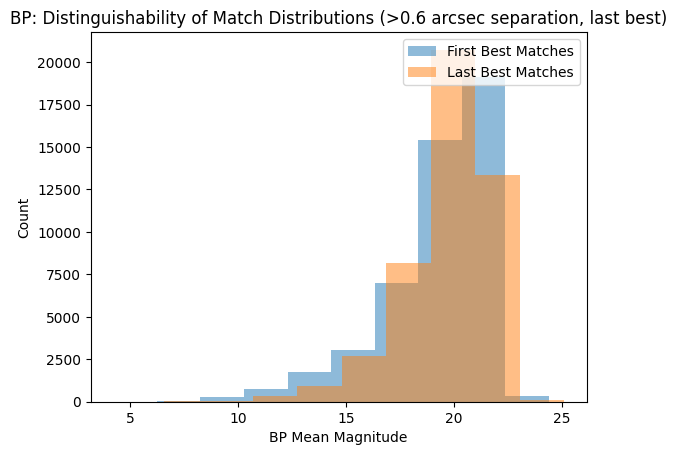

<Figure size 640x480 with 0 Axes>

In [247]:
# comparing distributions (first vs second best matches) with low distinguishability
data_first_match = first_match[(first_match["dist_arcsec"] > 0.6) & (first_match["dist_arcsec"] < float("inf"))]
data_last_match = last_match[last_match["chandra_source_id"].isin(data_first_match["chandra_source_id"])]

plt.hist(data_first_match["phot_bp_mean_mag"], alpha = 0.5, label = "First Best Matches")
plt.hist(data_last_match["phot_bp_mean_mag"], alpha = 0.5, label = "Last Best Matches")
plt.legend(loc = "upper right")
plt.xlabel("BP Mean Magnitude")
plt.ylabel("Count")
plt.title("BP: Distinguishability of Match Distributions (>0.6 arcsec separation, last best)")
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/BPMean/low_distinguishability_distributions_bpmean_last_match.png')

### RP Mean Magnitude

In [248]:
variable = "phot_rp_mean_mag"
filter_column1 = "dist_arcsec"
filter_column2 = "min_theta_mean"
filter_count = "first"
unique_id = "chandra_source_id"

# filter 1 and 2 range (separation)
filter1 = bin_edges[:-1]
filter2 = bin_edges[1:]

# filter 3 and 4 range (off-axis angle)
filter3 = [0, 3, 5]
filter4 = [3, 5, float("inf")] #

# KS test results
data = []

for i in range(len(filter1)):
    for j in range(len(filter3)):
        ks_test_results = ut.ks_test_filter_ranges(first_match, last_match, variable, filter_column1, filter_column2, 
                                                     filter1[i], filter2[i], filter3[j], filter4[j],
                                                     unique_id = unique_id, filter_count = filter_count)
        
        data.append({'statistic': ks_test_results[0], 'pvalue': ks_test_results[1], 
                                   'min_sep': filter1[i], 'max_sep': filter2[i], 'med_sep': (filter1[i] + filter2[i])/2,
                                   'min_offaxis': filter3[j], 'max_offaxis': filter4[j], 
                                   'filter_by': filter_count, 'n_first': ks_test_results[2], 'n_second': ks_test_results[3]})
        
ks_test_results_df = pd.DataFrame(data)

ks_test_results_df.to_csv("/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/data/processed_data/RPmean_ks_test_results_last_match.csv", index = False)

print(ks_test_results_df.head())

   statistic        pvalue   min_sep   max_sep   med_sep  min_offaxis  \
0   0.342142  1.061741e-37  0.000000  0.030257  0.015129            0   
1   0.435407  3.542321e-18  0.000000  0.030257  0.015129            3   
2   0.569444  4.087548e-11  0.000000  0.030257  0.015129            5   
3   0.338686  3.299056e-35  0.030257  0.048175  0.039216            0   
4   0.354067  5.018733e-12  0.030257  0.048175  0.039216            3   

   max_offaxis filter_by  n_first  n_second  
0          3.0     first      719       719  
1          5.0     first      209       209  
2          inf     first       72        72  
3          3.0     first      685       685  
4          5.0     first      209       209  


#### Thresholds

In [249]:
# Overall
overall_sep_01 = ks_test_results_df[ks_test_results_df["pvalue"] > 0.01].max_sep.min()
overall_sep_05 = ks_test_results_df[ks_test_results_df["pvalue"] > 0.05].max_sep.min()
overall_sep_10 = ks_test_results_df[ks_test_results_df["pvalue"] > 0.10].max_sep.min()

# 0-3 arcmin off-axis angle
offaxis_0_sep_01 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.01) & (ks_test_results_df["min_offaxis"] == 0)].max_sep.min()
offaxis_0_sep_05 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.05) & (ks_test_results_df["min_offaxis"] == 0)].max_sep.min()
offaxis_0_sep_10 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.10) & (ks_test_results_df["min_offaxis"] == 0)].max_sep.min()

# 3-5 arcmin off-axis angle
offaxis_3_sep_01 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.01) & (ks_test_results_df["min_offaxis"] == 3)].max_sep.min()
offaxis_3_sep_05 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.05) & (ks_test_results_df["min_offaxis"] == 3)].max_sep.min()
offaxis_3_sep_10 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.10) & (ks_test_results_df["min_offaxis"] == 3)].max_sep.min()

# >5 arcmin off-axis angle
offaxis_5_sep_01 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.01) & (ks_test_results_df["min_offaxis"] == 5)].max_sep.min()
offaxis_5_sep_05 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.05) & (ks_test_results_df["min_offaxis"] == 5)].max_sep.min()
offaxis_5_sep_10 = ks_test_results_df[(ks_test_results_df["pvalue"] > 0.10) & (ks_test_results_df["min_offaxis"] == 5)].max_sep.min()

thresholds = [{"sig_lvl": 0.01, "offaxis_stratif": "overall", "sep_threshold": overall_sep_01},
              {"sig_lvl": 0.05, "offaxis_stratif": "overall", "sep_threshold": overall_sep_05},
              {"sig_lvl": 0.10, "offaxis_stratif": "overall", "sep_threshold": overall_sep_10},
              {"sig_lvl": 0.01, "offaxis_stratif": "0-3", "sep_threshold": offaxis_0_sep_01},
              {"sig_lvl": 0.05, "offaxis_stratif": "0-3", "sep_threshold": offaxis_0_sep_05},
              {"sig_lvl": 0.10, "offaxis_stratif": "0-3", "sep_threshold": offaxis_0_sep_10},
              {"sig_lvl": 0.01, "offaxis_stratif": "3-5", "sep_threshold": offaxis_3_sep_01},
              {"sig_lvl": 0.05, "offaxis_stratif": "3-5", "sep_threshold": offaxis_3_sep_05},
              {"sig_lvl": 0.10, "offaxis_stratif": "3-5", "sep_threshold": offaxis_3_sep_10},
              {"sig_lvl": 0.01, "offaxis_stratif": ">5", "sep_threshold": offaxis_5_sep_01},
              {"sig_lvl": 0.05, "offaxis_stratif": ">5", "sep_threshold": offaxis_5_sep_05},
              {"sig_lvl": 0.10, "offaxis_stratif": ">5", "sep_threshold": offaxis_5_sep_10}]

thresholds = pd.DataFrame(thresholds)

thresholds.to_csv("/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/data/processed_data/RPmean_separation_thresholds_last_match.csv", index = False)

print(thresholds)

    sig_lvl offaxis_stratif  sep_threshold
0      0.01         overall       0.612642
1      0.05         overall       0.894024
2      0.10         overall       0.945972
3      0.01             0-3       0.612642
4      0.05             0-3       0.894024
5      0.10             0-3       0.945972
6      0.01             3-5       1.061833
7      0.05             3-5       1.250916
8      0.10             3-5       1.621270
9      0.01              >5       2.165748
10     0.05              >5       2.585526
11     0.10              >5       2.585526


#### Plots

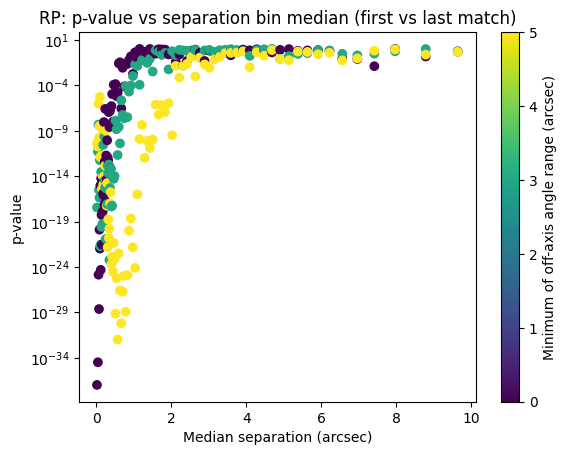

<Figure size 640x480 with 0 Axes>

In [250]:
# Plot p-values vs separation with title and color by off-axis angle
plt.scatter(ks_test_results_df['med_sep'], ks_test_results_df['pvalue'], c=ks_test_results_df['min_offaxis'])
plt.xlabel('Median separation (arcsec)')
plt.ylabel('p-value')
plt.title('RP: p-value vs separation bin median (first vs last match)')
plt.colorbar(label='Minimum of off-axis angle range (arcsec)')
plt.yscale("log")
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/RPMean/log_pvalue_vs_separation_bin_median_color_offaxis_aggregate_rpmean_last_match.png')

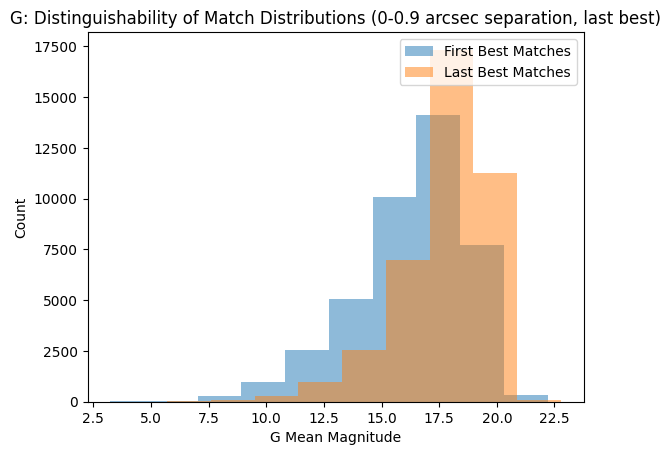

<Figure size 640x480 with 0 Axes>

In [251]:
# comparing distributions (first vs second best matches) with high distinguishability
data_first_match = first_match[(first_match["dist_arcsec"] > 0) & (first_match["dist_arcsec"] < 0.9)]
data_last_match = last_match[last_match["chandra_source_id"].isin(data_first_match["chandra_source_id"])]

plt.hist(data_first_match["phot_rp_mean_mag"], alpha = 0.5, label = "First Best Matches")
plt.hist(data_last_match["phot_rp_mean_mag"], alpha = 0.5, label = "Last Best Matches")
plt.legend(loc = "upper right")
plt.xlabel("G Mean Magnitude")
plt.ylabel("Count")
plt.title("G: Distinguishability of Match Distributions (0-0.9 arcsec separation, last best)")
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/GMean/high_distinguishability_distributions_gmean_last_match.png')

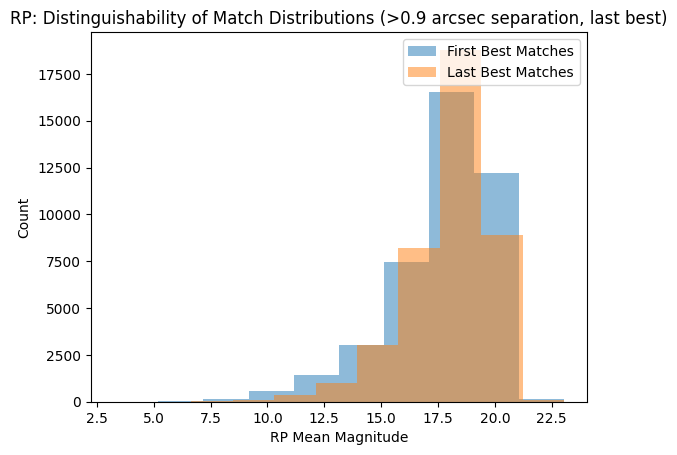

<Figure size 640x480 with 0 Axes>

In [252]:
# comparing distributions (first vs second best matches) with low distinguishability
data_first_match = first_match[(first_match["dist_arcsec"] > 0.9) & (first_match["dist_arcsec"] < float("inf"))]
data_last_match = last_match[last_match["chandra_source_id"].isin(data_first_match["chandra_source_id"])]

plt.hist(data_first_match["phot_rp_mean_mag"], alpha = 0.5, label = "First Best Matches")
plt.hist(data_last_match["phot_rp_mean_mag"], alpha = 0.5, label = "Last Best Matches")
plt.legend(loc = "upper right")
plt.xlabel("RP Mean Magnitude")
plt.ylabel("Count")
plt.title("RP: Distinguishability of Match Distributions (>0.9 arcsec separation, last best)")
plt.show()

plt.savefig('/Users/joshuaingram/Main/Projects/starsml/distinguishability_matches_analysis/figures/RPMean/low_distinguishability_distributions_rpmean_last_match.png')